In [331]:
import pandas as pd
import numpy as np 
import pandas_profiling as pp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import auc , roc_curve, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb

import umap
import matplotlib.patches as ln

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, FastICA

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import matplotlib.style as stl 
stl.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (25, 25)

In [452]:
train = pd.read_csv('../data/modulbank_train.csv', sep='\t', index_col=0)
test = pd.read_csv('../data/modulbank_test.csv', sep='\t', index_col=0 )
ytrain = train['0'].reset_index(drop=True)
xtrain = train.drop('0', axis=1).reset_index(drop=True)

In [453]:
skf = StratifiedKFold(n_splits=8, random_state=42)

In [454]:
const_columns = ['9', '140', '164'] 
const_in_test_1 = ['11']
const_in_test = ['5', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305']
zero_train_features = ['152', '160']


def preprocess(train_df, test_df):
    train = train_df.drop(const_columns, axis=1)
    test = test_df.drop(const_columns, axis=1)
    
    for column in const_in_test:
        train = train[train[column] == 0].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    for column in const_in_test_1:
        train = train[train[column] == 1].drop(column, axis=1)
        test.drop(column, axis=1, inplace=True)
        
    X_train = train.drop('0', axis=1).reset_index(drop=True)
    y_train = train['0'].reset_index(drop=True)
    X_test = test.drop('0', axis=1).reset_index(drop=True)
    return X_train, y_train, X_test

xtrain, ytrain, xtest = preprocess(train, test)


In [5]:
def get_results(estimator, skf, xtrain, ytrain, xtest):
    estimator.fit(xtrain, ytrain)
    predictions = estimator.predict_proba(xtest)[:, 1]
    
    predictions_cv = []
    k = 0
    for train_idx, val in skf.split(xtrain, ytrain):
        k+=1
        print("Fittng {k} fold")
        estimator.fit(xtrain.iloc[train_idx], ytrain.iloc[train_idx])
        predictions_cv.append([ytrain.iloc[val], estimator.predict_proba(xtrain.iloc[val])[:,1]])

    return predictions, predictions_cv

#### Попробуйте разние методи отбора признаков 

#### SELECTKBEST

In [6]:
base_score = cross_val_score(LogisticRegression(random_state=42), xtrain, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"Base score for default Logistic Regression is {round(base_score, 4) }")

Base score for default Logistic Regression is 0.7261


In [125]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.03,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.03,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 8, 
    'num_leaves': 128, 
    'min_data_in_leaf' : 17
    
    }

In [198]:
ks = np.arange(30, 330, 10)
k_scores = []
rf_scores = []
xgb_scores = []
lgb_scores = []

n_rounds = 10000
for k in ks:
    x_data_kbest = SelectKBest(f_classif, k=k).fit_transform(xtrain, ytrain)
    k_scores.append(cross_val_score(LogisticRegression(random_state=42), x_data_kbest, ytrain, cv=skf, scoring='roc_auc').mean())
    rf_scores.append(cross_val_score(RandomForestClassifier(random_state=42), x_data_kbest, ytrain, cv=skf, scoring='roc_auc').mean())
    
    lgb_train = lgb.Dataset(x_data_kbest, label=ytrain,  free_raw_data=False)
    result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(x_data_kbest, ytrain), 
                early_stopping_rounds=50, verbose_eval=0, )
    lgb_scores.append(result['auc-mean'][-1])
    
    xgb_train = xgb.DMatrix(x_data_kbest, ytrain)
    results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    xgb_scores.append(results['test-auc-mean'].iloc[-1])
    

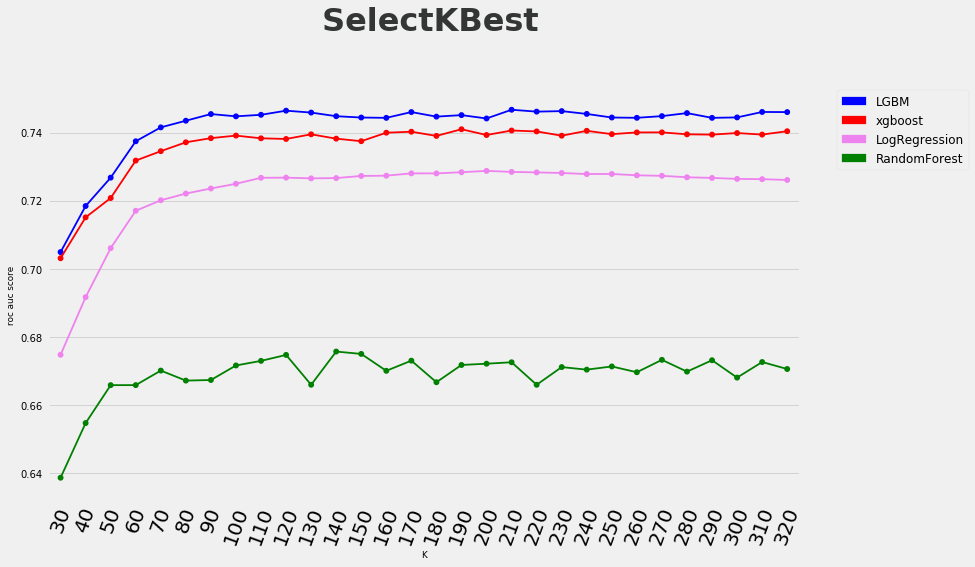

In [232]:
sns.set_context("paper", rc={'lines.linewidth':1})
f, ax = plt.subplots(1, 1)

plt.rcParams['figure.figsize'] = (12, 7)

sns.pointplot( ks, xgb_scores, ax=ax , size=1, markers='o', label='xgboost', color='red')
sns.pointplot(ks, lgb_scores,  size=1,  markers='o', label='lgbm', color='blue')
sns.pointplot(ks, k_scores,  size=1,  markers='o', label='logregression', color='violet')
fte = sns.pointplot(ks, rf_scores,  size=1,  markers='o', color='green')

fte.tick_params(axis='x', which='major', labelsize=20, rotation=70)
fte.tick_params(axis='y', which='major', labelsize=10)

fte.text(x = 10, y = 0.77, s = " SelectKBest", fontsize = 32, weight = 'bold', color = '#343635')

plt.xlabel('K')
plt.ylabel('roc auc score')


blue_line = ln.Patch(color='blue', label='LGBM')
red_line = ln.Patch(color='red', label='xgboost')
green_line = ln.Patch(color='green',  label='RandomForest')
vio_line = ln.Patch(color='violet',  label='LogRegression')

ax.legend(handles=[blue_line, red_line, vio_line, green_line] , bbox_to_anchor=[1.05, 1], fontsize=12, borderaxespad=0.)

In [47]:
x_data_kbest = SelectKBest(f_classif, k=200).fit_transform(xtrain, ytrain)
lg_score = cross_val_score(LogisticRegression(C=0.4,  solver='sag',  random_state=42), x_data_kbest, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"Logregression score on 200 features {round(lg_score, 4)}, difff  + {round(lg_score - base_score, 4)}")

Logregression score on 200 features 0.7291, difff  + 0.003


In [48]:
#mutual_info_classif - works but worse than f_classif
from sklearn.feature_selection import mutual_info_classif
ks = np.arange(30, 320, 10)
k_scores = []
for k in ks:
    x_data_kbest = SelectKBest(mutual_info_classif, k=k).fit_transform(xtrain, ytrain)
    k_scores.append(cross_val_score(LogisticRegression(random_state=42), x_data_kbest, ytrain, cv=skf, scoring='roc_auc').mean())

Text(0,0.5,'roc auc score')

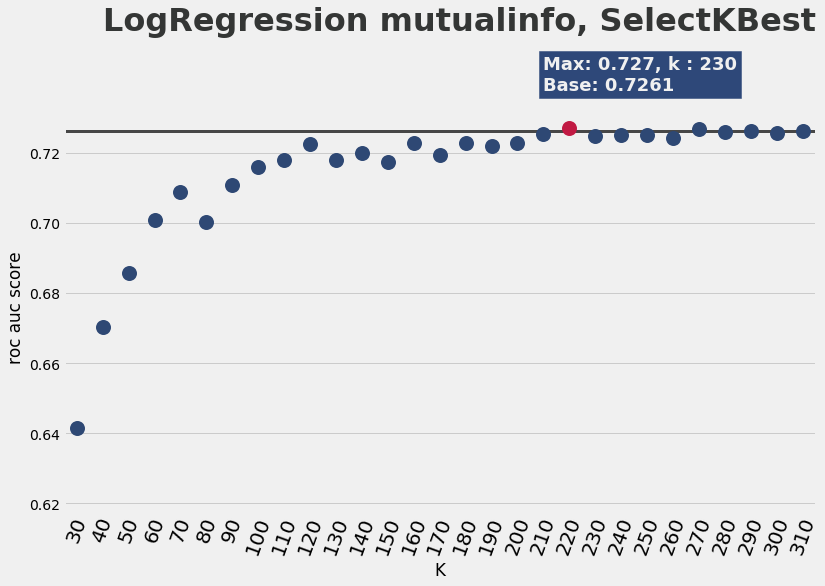

In [56]:
plt.rcParams['figure.figsize'] = (12, 7)
colors  = ['#2e4874' if (x < max(k_scores)) else '#c11a43' for x in k_scores ]

fte = sns.swarmplot(ks, k_scores, palette=colors, size=15)
fte.tick_params(axis='x', which='major', labelsize=20, rotation=70)
fte.axhline(y = base_score, color = 'black', linewidth = 3, alpha = .7)

fte.text(x=18, y=0.738, s=f"Max: {round(max(k_scores), 4)}, k : 230\nBase: {round(base_score, 4)}", 
         fontsize= 18, weight ='bold', color='#f0f0f0', backgroundcolor='#2e4879',)
fte.text(x = 1, y = 0.755, s = "LogRegression mutualinfo, SelectKBest", fontsize = 32, weight = 'bold', color = '#343635')

plt.xlabel('K')
plt.ylabel('roc auc score')

In [233]:
def get_results(estimator, skf, xtrain, ytrain, xtest):
    estimator.fit(xtrain, ytrain)
    predictions = estimator.predict_proba(xtest)[:, 1]
    
    predictions_cv = []
    k = 0
    for train_idx, val in skf.split(xtrain, ytrain):
        k+=1
        print("Fittng {k} fold")
        estimator.fit(xtrain.iloc[train_idx], ytrain.iloc[train_idx])
        predictions_cv.append([ytrain.iloc[val], estimator.predict_proba(xtrain.iloc[val])[:,1]])

    return predictions, predictions_cv

In [80]:

x_data_kbest = SelectKBest(f_classif, k=200).fit(xtrain, ytrain)
idxs_selected = x_data_kbest.get_support(indices=True)
kbest_200 = xtrain.iloc[:, idxs_selected].columns.values



In [236]:
#get results for futher stacking and stuff like this
log_predictions, log_predictions_cv = get_results(LogisticRegression(C=0.4,  solver='sag',  random_state=42),
                                                  skf, xtrain[kbest_200], ytrain, xtest[kbest_200])

In [279]:
x_data_kbest = SelectKBest(f_classif, k=190).fit_transform(xtrain, ytrain)

params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(x_data_kbest, ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
results['test-auc-mean'].iloc[-1]
    

0.7420459999999999

In [ ]:
0.7397753333333333 - base  xgboost 
0.7410413333333334 - 190  xgboost
0.7420459999999999 - 190 + (eta = 0.01)

In [720]:
0.7410413333333334 - 0.7397753333333333

0.0012660000000001004

In [719]:
x_data_kbest = SelectKBest(f_classif, k=190).fit(xtrain, ytrain)
idxs_selected = x_data_kbest.get_support(indices=True)
kbest_190 = xtrain.iloc[:, idxs_selected].columns.values

xgb_train = xgb.DMatrix(xtrain[kbest_190], ytrain)
xgb_test= xgb.DMatrix(xtest[kbest_190])
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
xgb_predictions = xgb_model.predict(xgb_test)

In [281]:
xgb_predictions_cv = []
for train_idx, val in skf.split(xtrain, ytrain):
    xgb_train = xgb.DMatrix(xtrain[kbest_190].iloc[train_idx], ytrain.iloc[train_idx])
    xgb_test= xgb.DMatrix(xtrain[kbest_190].iloc[val])
    
    xgb_model = xgb.train(params_xgb, xgb_train, len(results))
    xgb_predictions_ = xgb_model.predict(xgb_test)

    xgb_predictions_cv.append([ytrain.iloc[val], xgb_predictions_])

LGBM

In [285]:
lgb_scores_n = []

n_rounds = 10000
for k in ks:
    x_data_kbest = SelectKBest(f_classif, k=k).fit_transform(xtrain, ytrain)
    
    lgb_train = lgb.Dataset(x_data_kbest, label=ytrain,  free_raw_data=False)
    result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(x_data_kbest, ytrain), 
                early_stopping_rounds=50, verbose_eval=0, )
    lgb_scores_n.append(result['auc-mean'][-1])
    
   

Text(0,0.5,'roc auc score')

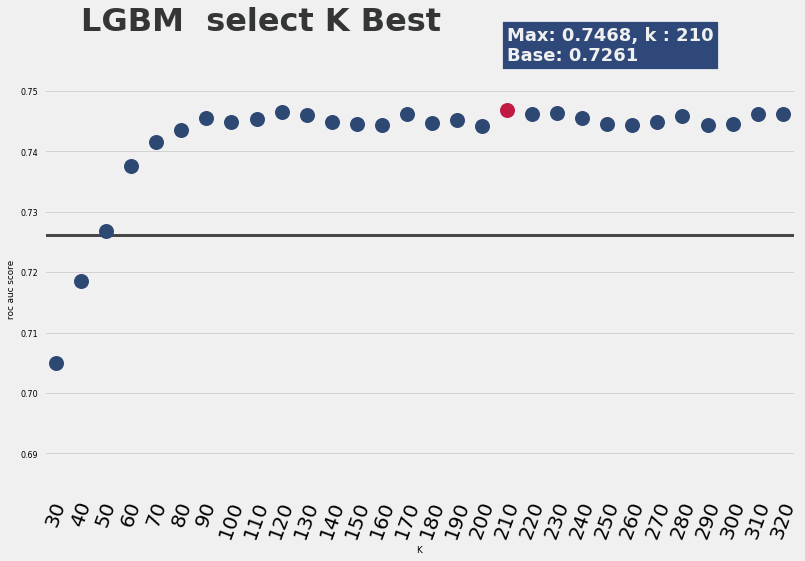

In [295]:
plt.rcParams['figure.figsize'] = (12, 7)
colors  = ['#2e4874' if (x < max(lgb_scores_n)) else '#c11a43' for x in lgb_scores_n ]

fte = sns.swarmplot(ks, lgb_scores_n, palette=colors, size=15)
fte.tick_params(axis='x', which='major', labelsize=20, rotation=70)
fte.axhline(y = base_score, color = 'black', linewidth = 3, alpha = .7)

fte.text(x=18, y=0.755, s=f"Max: {round(max(lgb_scores_n), 4)}, k : 210\n}", 
         fontsize= 18, weight ='bold', color='#f0f0f0', backgroundcolor='#2e4879',)
fte.text(x = 1, y = 0.76, s = "LGBM  select K Best ", fontsize = 32, weight = 'bold', color = '#343635')

plt.xlabel('K')
plt.ylabel('roc auc score')

In [301]:
x_data_kbest = SelectKBest(f_classif, k=210).fit_transform(xtrain, ytrain)

params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 8, 
    'num_leaves': 128, 
    'min_data_in_leaf' : 17
    
    }

n_rounds = 10000
lgb_train = lgb.Dataset(x_data_kbest, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(x_data_kbest, ytrain), 
                early_stopping_rounds=100, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.674946 + 0.00611954
[2]	cv_agg's auc: 0.695749 + 0.00696529
[3]	cv_agg's auc: 0.706741 + 0.00851894
[4]	cv_agg's auc: 0.710333 + 0.00846495
[5]	cv_agg's auc: 0.712717 + 0.00817064
[6]	cv_agg's auc: 0.71432 + 0.00954291
[7]	cv_agg's auc: 0.715426 + 0.00859542
[8]	cv_agg's auc: 0.717847 + 0.00796167
[9]	cv_agg's auc: 0.718564 + 0.00747029
[10]	cv_agg's auc: 0.719019 + 0.00817708
[11]	cv_agg's auc: 0.719367 + 0.00854646
[12]	cv_agg's auc: 0.719911 + 0.00775907
[13]	cv_agg's auc: 0.72105 + 0.00752732
[14]	cv_agg's auc: 0.721312 + 0.00733335
[15]	cv_agg's auc: 0.72167 + 0.00743596
[16]	cv_agg's auc: 0.722318 + 0.00748196
[17]	cv_agg's auc: 0.722268 + 0.00715615
[18]	cv_agg's auc: 0.72288 + 0.00693295
[19]	cv_agg's auc: 0.723619 + 0.00671963
[20]	cv_agg's auc: 0.723917 + 0.00674312
[21]	cv_agg's auc: 0.724078 + 0.00647613
[22]	cv_agg's auc: 0.724559 + 0.00607617
[23]	cv_agg's auc: 0.724914 + 0.00582077
[24]	cv_agg's auc: 0.725129 + 0.00540613
[25]	cv_agg's auc: 0.725152 +

[200]	cv_agg's auc: 0.737581 + 0.00654668
[201]	cv_agg's auc: 0.73759 + 0.00655594
[202]	cv_agg's auc: 0.737611 + 0.00660781
[203]	cv_agg's auc: 0.737684 + 0.00657692
[204]	cv_agg's auc: 0.737789 + 0.00655411
[205]	cv_agg's auc: 0.737797 + 0.00664862
[206]	cv_agg's auc: 0.737867 + 0.00667937
[207]	cv_agg's auc: 0.737899 + 0.00665279
[208]	cv_agg's auc: 0.73795 + 0.00664367
[209]	cv_agg's auc: 0.738065 + 0.00666143
[210]	cv_agg's auc: 0.73808 + 0.00669109
[211]	cv_agg's auc: 0.738165 + 0.00667503
[212]	cv_agg's auc: 0.738253 + 0.0067286
[213]	cv_agg's auc: 0.73826 + 0.0067216
[214]	cv_agg's auc: 0.738353 + 0.0066637
[215]	cv_agg's auc: 0.738377 + 0.00672011
[216]	cv_agg's auc: 0.738417 + 0.00675972
[217]	cv_agg's auc: 0.738452 + 0.00679744
[218]	cv_agg's auc: 0.738516 + 0.00678308
[219]	cv_agg's auc: 0.73861 + 0.00679689
[220]	cv_agg's auc: 0.738632 + 0.00684064
[221]	cv_agg's auc: 0.738723 + 0.00685862
[222]	cv_agg's auc: 0.738752 + 0.00683873
[223]	cv_agg's auc: 0.738841 + 0.00686067


[397]	cv_agg's auc: 0.744871 + 0.00720555
[398]	cv_agg's auc: 0.744863 + 0.00719169
[399]	cv_agg's auc: 0.744894 + 0.0072277
[400]	cv_agg's auc: 0.744924 + 0.00724945
[401]	cv_agg's auc: 0.744975 + 0.00725763
[402]	cv_agg's auc: 0.745017 + 0.00724358
[403]	cv_agg's auc: 0.745043 + 0.00724117
[404]	cv_agg's auc: 0.745064 + 0.00723403
[405]	cv_agg's auc: 0.74511 + 0.00725764
[406]	cv_agg's auc: 0.745116 + 0.00720344
[407]	cv_agg's auc: 0.745103 + 0.0072332
[408]	cv_agg's auc: 0.745125 + 0.00723224
[409]	cv_agg's auc: 0.745161 + 0.00724938
[410]	cv_agg's auc: 0.745193 + 0.00724019
[411]	cv_agg's auc: 0.745233 + 0.00722024
[412]	cv_agg's auc: 0.745246 + 0.00726279
[413]	cv_agg's auc: 0.74525 + 0.00729168
[414]	cv_agg's auc: 0.745269 + 0.00725757
[415]	cv_agg's auc: 0.745263 + 0.00727549
[416]	cv_agg's auc: 0.74531 + 0.00727745
[417]	cv_agg's auc: 0.745332 + 0.00724964
[418]	cv_agg's auc: 0.745312 + 0.0073256
[419]	cv_agg's auc: 0.745345 + 0.00734369
[420]	cv_agg's auc: 0.745405 + 0.0073317

[594]	cv_agg's auc: 0.747365 + 0.00800143
[595]	cv_agg's auc: 0.747364 + 0.00800651
[596]	cv_agg's auc: 0.747371 + 0.00801414
[597]	cv_agg's auc: 0.74737 + 0.00799753
[598]	cv_agg's auc: 0.747403 + 0.00800748
[599]	cv_agg's auc: 0.747437 + 0.00802253
[600]	cv_agg's auc: 0.747442 + 0.00804445
[601]	cv_agg's auc: 0.747433 + 0.00804323
[602]	cv_agg's auc: 0.747449 + 0.0081064
[603]	cv_agg's auc: 0.747438 + 0.0081203
[604]	cv_agg's auc: 0.747454 + 0.00813228
[605]	cv_agg's auc: 0.747455 + 0.00813325
[606]	cv_agg's auc: 0.747435 + 0.0081187
[607]	cv_agg's auc: 0.747453 + 0.00812302
[608]	cv_agg's auc: 0.74744 + 0.00813593
[609]	cv_agg's auc: 0.747449 + 0.00812462
[610]	cv_agg's auc: 0.747468 + 0.00811966
[611]	cv_agg's auc: 0.747484 + 0.00811851
[612]	cv_agg's auc: 0.747503 + 0.00811431
[613]	cv_agg's auc: 0.747483 + 0.00810168
[614]	cv_agg's auc: 0.747516 + 0.00809088
[615]	cv_agg's auc: 0.747511 + 0.00807108
[616]	cv_agg's auc: 0.747512 + 0.00808111
[617]	cv_agg's auc: 0.747539 + 0.008101

[792]	cv_agg's auc: 0.748144 + 0.00861587
[793]	cv_agg's auc: 0.748168 + 0.0086146
[794]	cv_agg's auc: 0.748179 + 0.00861296
[795]	cv_agg's auc: 0.748189 + 0.00862196
[796]	cv_agg's auc: 0.748191 + 0.00865182
[797]	cv_agg's auc: 0.748188 + 0.00865577
[798]	cv_agg's auc: 0.748194 + 0.00864927
[799]	cv_agg's auc: 0.748193 + 0.00865572
[800]	cv_agg's auc: 0.748193 + 0.00866975
[801]	cv_agg's auc: 0.748203 + 0.00867318
[802]	cv_agg's auc: 0.748199 + 0.00868297
[803]	cv_agg's auc: 0.748218 + 0.00870194
[804]	cv_agg's auc: 0.748199 + 0.00871019
[805]	cv_agg's auc: 0.748194 + 0.00872022
[806]	cv_agg's auc: 0.748226 + 0.00872955
[807]	cv_agg's auc: 0.748218 + 0.008737
[808]	cv_agg's auc: 0.748197 + 0.008741
[809]	cv_agg's auc: 0.748169 + 0.00874029
[810]	cv_agg's auc: 0.748167 + 0.00872199
[811]	cv_agg's auc: 0.74815 + 0.00875033
[812]	cv_agg's auc: 0.748153 + 0.00875808
[813]	cv_agg's auc: 0.748164 + 0.00875741
[814]	cv_agg's auc: 0.748182 + 0.0087233
[815]	cv_agg's auc: 0.748202 + 0.00871418

0.7482580978382237

In [ ]:
base 0.7467692837749486
xdata210 best 0.74825809783822

In [723]:
0.74825809783822 - 0.7467692837749486

0.001488814063271393

In [303]:
x_data_kbest = SelectKBest(f_classif, k=210).fit(xtrain, ytrain)
idxs_selected = x_data_kbest.get_support(indices=True)
kbest_210 = xtrain.iloc[:, idxs_selected].columns.values

lgb_train = lgb.Dataset(xtrain[kbest_210], label=ytrain,  free_raw_data=False)

lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))

lgb_predictions = lgb_model.predict(xtest[kbest_210])
lgb_predictions_cv = []
k = 0
for train_idx, val in skf.split(xtrain, ytrain):
    k += 1
    print(k)
    lgb_train = lgb.Dataset(xtrain[kbest_210].iloc[train_idx], label=ytrain.iloc[train_idx],  free_raw_data=False)
    lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))
    lgb_predictions_= lgb_model.predict(xtrain[kbest_210].iloc[val])
    
    lgb_predictions_cv.append([ytrain.iloc[val], lgb_predictions_])

1
2
3
4
5
6
7
8


Best score is 0.7486260730134779


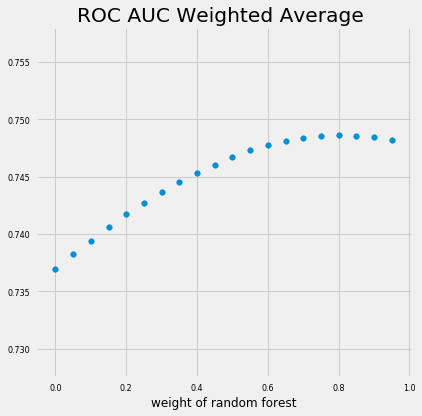

In [761]:
# simple weighted average
mus = np.arange(0, 20) * 0.05
scores = [np.mean([roc_auc_score(rf_p[0], rf_p[1]*mu + lg_p[1]*(1-mu)) for rf_p, lg_p in zip(lgb_predictions_cv, rf_predictions_cv)])\
          for mu in mus]
print(f"Best score is {np.max(scores)}")
#vizualizing
plt.rcParams['figure.figsize'] = 6, 6
plt.title('ROC AUC Weighted Average ')
plt.xlabel('weight of random forest', fontsize=12)
plt.scatter(mus, scores)   
# # without feature selection 0.7420 -  PublicLB 0.7481 (see hw 5)    + 0.003

In [765]:
 # with feature selection 0.748626 -  PublicLB 0.7513 

In [243]:
%%time
best_log = LogisticRegression(C=0.4,  solver='sag',  random_state=42)
best_bag = BaggingClassifier(base_estimator=best_log, n_estimators=50, max_features=0.9)
bag_predictions_p, bag_predictions_cv_p = get_results(best_bag, skf, xtrain[kbest_200], ytrain, xtest[kbest_200])

Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
CPU times: user 38min 22s, sys: 10.1 s, total: 38min 32s
Wall time: 38min 57s


In [245]:
### %%time
lr = LogisticRegression(C=0.1, max_iter=100, n_jobs=1, penalty='l2', random_state=42, solver='sag', verbose=0)
best_bag = BaggingClassifier(base_estimator=lr, n_estimators=50, max_features=0.6)
bag_predictions, bag_predictions_cv = get_results(best_bag, skf, xtrain, ytrain, xtest)

Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold


In [261]:
%%time
rf = RandomForestClassifier(random_state=42, criterion='entropy', n_jobs=4)
param_grid = {'max_features': (  0.2, 0.5, 0.8, 0.9,  1),
            'max_depth': (15, 20, 25),
            'min_samples_leaf':(7,2,),
            'n_estimators': [75]} 
grid_cv_rf = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc', verbose=2, n_jobs=4)
grid_cv_rf.fit(x_data_k_best, ytrain)
best_rf = grid_cv_rf.best_estimator_
rf_score = grid_cv_rf.best_score_
print(f"CV score {rf_score}")


Fitting 8 folds for each of 30 candidates, totalling 240 fits
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  19.0s
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  19.2s
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  19.4s
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  19.3s
[CV] max_depth=15, max_features=0.2, min_samples_leaf=7, n_estim

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.8min


[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.2min
[CV] max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.2min
[CV] max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.2min
[CV] max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.2min
[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.3min
[CV] max_depth=15, max_features=0.8, min_samples_leaf=2, n_estimators=75 
[CV] max_depth=15, max_features=0.8, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=15, max_features=0.8, min_samples_leaf=7, n_estimators=75, total= 1.3min
[CV] max_depth=15, max_features=0.8, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=15, ma

[CV]  max_depth=20, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  22.8s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  23.1s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  23.0s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.2, min_samples_leaf=7, n_estimators=75, total=  23.0s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75, total=  24.7s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75, total=  24.5s
[CV] max_depth=20, max_features=0.2, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, ma

[CV]  max_depth=20, max_features=0.9, min_samples_leaf=7, n_estimators=75, total= 1.7min
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75, total= 1.8min
[CV]  max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75, total= 1.8min
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75, total= 1.8min
[CV]  max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75, total= 1.8min
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV] max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=0.9, min_samples_leaf=2, n_estimators=75, total= 1.8min
[CV] max_depth=20, max

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 34.7min


[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.7s
[CV] max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.9s
[CV] max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75 
[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.9s
[CV] max_depth=25, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.9s
[CV] max_depth=25, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.7s
[CV] max_depth=25, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=20, max_features=1, min_samples_leaf=2, n_estimators=75, total=   2.9s
[CV] max_depth=25, max_features=0.2, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.2, 

[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.8, min_samples_leaf=2, n_estimators=75, total= 2.0min
[CV]  max_depth=25, max_features=0.8, min_samples_leaf=2, n_estimators=75, total= 2.0min
[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.8, min_samples_leaf=2, n_estimators=75, total= 2.0min
[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75, total= 1.8min
[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75, total= 1.8min
[CV] max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75 
[CV]  max_depth=25, max_features=0.9, min_samples_leaf=7, n_estimators=75, total= 1.8min
[CV] max_depth=25, max

[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 61.8min finished


CV score 0.7369138359020952
CPU times: user 1min 4s, sys: 1.22 s, total: 1min 6s
Wall time: 1h 2min


In [267]:
rf = RandomForestClassifier(criterion='entropy', max_depth=20, max_features=0.5, min_samples_leaf=7, 
                            min_samples_split=2, n_estimators=75, n_jobs=4, random_state=42)
x_data_k_best = SelectKBest(f_classif, 140).fit_transform(xtrain,  ytrain)
rf_score = cross_val_score(rf, x_data_k_best, ytrain, scoring='roc_auc', cv=skf).mean()
print(f"RandomForest score on 140 features {round(rf_score, 4)}")

RandomForest score on 140 features 0.7369


In [269]:
x_data_kbest = SelectKBest(f_classif, k=140).fit(xtrain, ytrain)
idxs_selected = x_data_kbest.get_support(indices=True)
kbest_140 = xtrain.iloc[:, idxs_selected].columns.values
rf_predictions, rf_predictions_cv = get_results(rf, skf, xtrain[kbest_140], ytrain, xtest[kbest_140])

Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold


In [ ]:
rf_perdictions_cv, log_predictions_cv, bag_predictions_cv, bag_predictions_cv_p

Best score is 0.7450547572428554


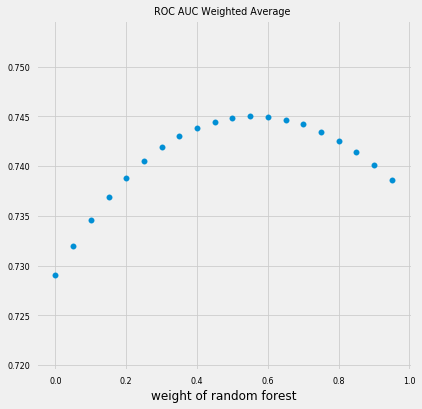

In [270]:
# simple weighted average
mus = np.arange(0, 20) * 0.05
scores = [np.mean([roc_auc_score(rf_p[0], rf_p[1]*mu + lg_p[1]*(1-mu)) for rf_p, lg_p in zip(rf_predictions_cv, log_predictions_cv)])\
          for mu in mus]
print(f"Best score is {np.max(scores)}")
#vizualizing
plt.rcParams['figure.figsize'] = 6, 6
plt.title('ROC AUC Weighted Average ')
plt.xlabel('weight of random forest', fontsize=12)
plt.scatter(mus, scores)   
# # without feature selection 0.7420 -  PublicLB 0.7481 (see hw 5)    + 0.003

In [ ]:
lgb_predictions_cv, xgb_predictions_cv, bag_predictions_cv_p, bag_predictions_cv,  rf_predictions_cv

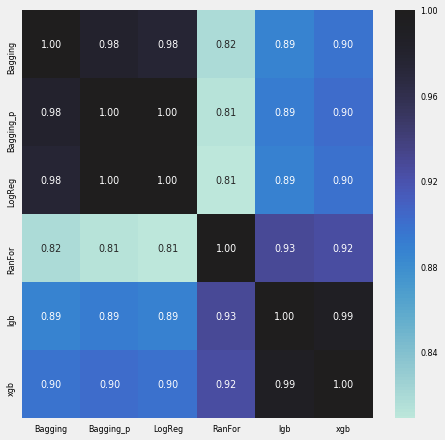

In [320]:
plt.rcParams['figure.figsize'] = 7, 7
preds = pd.DataFrame({'LogReg': log_predictions, 'RanFor':rf_predictions,
              'xgb' : xgb_predictions, 'Bagging': bag_predictions, 'Bagging_p': bag_predictions_p, 'lgb': lgb_predictions})
sns.heatmap(preds.corr(), annot=True, fmt='.2f', center = True)

In [316]:
xtrain_stacked = xtrain.copy()
xtest_stacked = xtest.copy()

xtrain_stacked["log_preds"] = 0
xtrain_stacked["rf_preds"] = 0
xtrain_stacked["bag_preds"] = 0
xtrain_stacked["bag_p_preds"] = 0
xtrain_stacked['lgb_preds'] = 0
xtrain_stacked['xgb_preds'] = 0

xtest_stacked["log_preds"] = log_predictions
xtest_stacked["rf_preds"] = rf_predictions
xtest_stacked["bag_preds"] = bag_predictions
xtest_stacked["bag_p_preds"] = bag_predictions_p
xtest_stacked["lgb_prds"] = lgb_predictions
xtest_stacked['xgb_preds'] = xgb_predictions


for i, fold in enumerate(skf.split(xtrain, ytrain)):
    train, val = fold[0], fold[1]
    xtrain_stacked.iloc[val, -6] = log_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -5] = rf_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -4] = bag_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -3] = bag_predictions_cv_p[i][1]
    xtrain_stacked.iloc[val, -2] = lgb_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -1] = xgb_predictions_cv[i][1]
 
 
    

In [318]:
%%time
meta_estmator = LogisticRegression(penalty='l1', random_state=42)
base_stack_score = cross_val_score(meta_estmator, xtrain_stacked, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"CV score {base_stack_score}")
#LB 0.7502

CV score 0.7487516951999001
CPU times: user 1min 8s, sys: 735 ms, total: 1min 9s
Wall time: 1min 9s


In [321]:
xtrain_stacked = xtrain.copy()
xtest_stacked = xtest.copy()

xtrain_stacked["log_preds"] = 0
xtrain_stacked["rf_preds"] = 0
xtrain_stacked["bag_preds"] = 0
xtrain_stacked["bag_p_preds"] = 0
xtrain_stacked['lgb_preds'] = 0
xtrain_stacked['xgb_preds'] = 0

xtest_stacked["log_preds"] = log_predictions
xtest_stacked["rf_preds"] = rf_predictions
xtest_stacked["bag_preds"] = bag_predictions
xtest_stacked["bag_p_preds"] = bag_predictions_p
xtest_stacked["lgb_prds"] = lgb_predictions
xtest_stacked['xgb_preds'] = xgb_predictions


for i, fold in enumerate(skf.split(xtrain, ytrain)):
    train, val = fold[0], fold[1]
    xtrain_stacked.iloc[val, -6] = log_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -5] = rf_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -4] = bag_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -3] = bag_predictions_cv_p[i][1]
    xtrain_stacked.iloc[val, -2] = lgb_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -1] = xgb_predictions_cv[i][1]
 

meta_estmator = LogisticRegression(penalty='l1', random_state=42)
base_stack_score = cross_val_score(meta_estmator, xtrain_stacked, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"CV score {base_stack_score}")
#LB 0.7502
    

CV score 0.7487679462435143


In [324]:
xtrain_stacked = xtrain.copy()
xtest_stacked = xtest.copy()

xtrain_stacked["log_preds"] = 0
xtrain_stacked["rf_preds"] = 0
xtrain_stacked["bag_preds"] = 0

xtrain_stacked['lgb_preds'] = 0
xtrain_stacked['xgb_preds'] = 0

xtest_stacked["log_preds"] = log_predictions
xtest_stacked["rf_preds"] = rf_predictions
xtest_stacked["bag_preds"] = bag_predictions

xtest_stacked["lgb_prds"] = lgb_predictions



for i, fold in enumerate(skf.split(xtrain, ytrain)):
    train, val = fold[0], fold[1]
    xtrain_stacked.iloc[val, -5] = log_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -4] = rf_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -3] = bag_predictions_cv[i][1]

    xtrain_stacked.iloc[val, -2] = lgb_predictions_cv[i][1]
    xtrain_stacked.iloc[val, -1] = xgb_predictions_cv[i][1]
 

meta_estmator = LogisticRegression(penalty='l1', random_state=42)
base_stack_score = cross_val_score(meta_estmator, xtrain_stacked, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"CV score {base_stack_score}")
#LB 0.7502
    

CV score 0.7486715762683092


In [ ]:
cross_val_score(rf, xtrain, ytrain, scoring='roc_auc', cv=skf)

In [87]:
pipe = make_pipeline(
    SelectFromModel(rf),
    LogisticRegression(random_state = 42)
)


In [88]:
cross_val_score(pipe, xtrain, ytrain, scoring='roc_auc', cv=skf).mean()

0.7072347794123925

In [102]:
?SelectFromModel

In [86]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [85]:
pipe = make_pipeline(
    SelectFromModel(estimator=RandomForestClassifier(random_state=42)),
    RandomForestClassifier(random_state=42)
)
cross_val_score(pipe, xtrain, ytrain, scoring='roc_auc', cv=skf).mean()

0.6656942689115883

In [90]:
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=4,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [100]:
tiles = [pd.Series(rf.feature_importances_).quantile(x) for x in np.arange(0,100, 5)*0.01] + [5:]

In [107]:
cv_scores = []
for t in tiles :
    data = SelectFromModel(estimator=rf, threshold=t).fit_transform(xtrain, ytrain)
    cv_score = cross_val_score(LogisticRegression(random_state=42), data, ytrain, scoring='roc_auc', cv=skf).mean()
    cv_scores.append(cv_score)
    print(t, '  ', cv_score)

0.0    0.7260974697241838
1.9446314666607918e-05    0.7272205445801256
4.313638846547614e-05    0.7266882934030872
8.238937115409498e-05    0.7269319270942411
0.0001406956748153087    0.7270029597704477
0.0002701789715489331    0.726266319650279
0.0005478823586112388    0.7223661950108867
0.0009646372201187863    0.7195235296914029


KeyboardInterrupt: 

In [120]:
td = [x for x in np.linspace(0,0.00005, 25 )]
for t in td :
    data = SelectFromModel(estimator=rf, threshold=t).fit_transform(xtrain, ytrain)
    cv_score = cross_val_score(LogisticRegression(random_state=42), data, ytrain, scoring='roc_auc', cv=skf).mean()
    cv_scores.append(cv_score)
    print(t, '  ', cv_score)

0.0    0.7260974697241838
3.75e-06    0.7270634465825148
7.5e-06    0.7271254820443851
1.125e-05    0.7271828810489743
1.5e-05    0.7272671292223419
1.8750000000000002e-05    0.7272205445801256
2.25e-05    0.7273076220558696
2.625e-05    0.727365360814349
3e-05    0.7272731303341693
3.375e-05    0.7272731303341693
3.7500000000000003e-05    0.7273554417231202
4.125e-05    0.7272585568838166
4.5e-05    0.7266030868879967
4.875e-05    0.7267709338415795


KeyboardInterrupt: 

In [325]:
best_svc = SVC(C=10, random_state=42, probability=True)
svc_predictions, svc_predictions_cv = get_results(best_svc, skf, xtrain, ytrain, xtest)

Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold
Fittng {k} fold


In [470]:
xgtrain = xtrain.copy()
xgtrain['165_337'] = np.sqrt( xgtrain['165'] * xgtrain['337'] )

xgtrain.drop(['337'], axis=1, inplace=True)
xgtrain.drop(['165'], axis=1, inplace=True)

xgtest = xtest.copy()
xgtest['165_337'] = np.sqrt( xgtest['165'] * xgtest['337'] )

xgtest.drop(['337'], axis=1, inplace=True)
xgtest.drop(['165'], axis=1, inplace=True)

def remove_ohe(row):
    if row['1'] == 1:
        return 1 
    elif row['2'] == 1:
        return 2
    elif row['3'] == 1:
        return 3
    else:
        return 0 

xgtrain['1_2_3'] = xgtrain.apply(lambda row : remove_ohe(row), axis=1) 
xgtrain.drop(['1', '2', '3'], axis = 1, inplace=True )
xgtest['1_2_3'] = xgtest.apply(lambda row : remove_ohe(row), axis=1) 
xgtest.drop(['1', '2', '3'], axis = 1, inplace=True )


In [326]:
xgtrain = xtrain.copy()
xgtrain['165_337'] = np.sqrt( xgtrain['165'] * xgtrain['337'] )

xgtrain.drop(['337'], axis=1, inplace=True)
xgtrain.drop(['165'], axis=1, inplace=True)

xgtest = xtest.copy()
xgtest['165_337'] = np.sqrt( xgtest['165'] * xgtest['337'] )

xgtest.drop(['337'], axis=1, inplace=True)
xgtest.drop(['165'], axis=1, inplace=True)

def remove_ohe(row):
    if row['1'] == 1:
        return 1 
    elif row['2'] == 1:
        return 2
    elif row['3'] == 1:
        return 3
    else:
        return 0 

xgtrain['1_2_3'] = xgtrain.apply(lambda row : remove_ohe(row), axis=1) 
xgtrain.drop(['1', '2', '3'], axis = 1, inplace=True )
xgtest['1_2_3'] = xgtest.apply(lambda row : remove_ohe(row), axis=1) 
xgtest.drop(['1', '2', '3'], axis = 1, inplace=True )



params_xgb_rf = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 32,
    "eval_metric": 'auc',
   
    
    'max_depth':  9,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(xgtrain, ytrain, feature_names=xgtrain.columns)

nrounds = 10000
results_rf = xgb.cv(params_xgb_rf, xgb_train, num_boost_round=nrounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)

xgb_test= xgb.DMatrix(xgtest)
xgb_model = xgb.train(params_xgb_rf, xgb_train, len(results_rf))
xgb_predictions_rf = xgb_model.predict(xgb_test)

xgb_predictions_rf_cv = []
k = 0
seed = 42
skf = StratifiedKFold(n_splits=8, random_state=seed)
for train_idx, val in skf.split(xtrain, ytrain):
    k+=1
    print(f"Fittng {k} fold")
    
    xgb_train = xgb.DMatrix(xgtrain.iloc[train_idx], ytrain.iloc[train_idx])
    xgb_test= xgb.DMatrix(xgtrain.iloc[val])
    
    xgb_model = xgb.train(params_xgb_rf, xgb_train, len(results_rf))
    xgb_predictions_ = xgb_model.predict(xgb_test)

    xgb_predictions_rf_cv.append([ytrain.iloc[val], xgb_predictions_])



[0]	train-auc:0.707803+0.00482198	test-auc:0.667823+0.00823553
[1]	train-auc:0.733302+0.00437719	test-auc:0.690927+0.0124564
[2]	train-auc:0.745328+0.00406721	test-auc:0.700221+0.0102109
[3]	train-auc:0.749664+0.0053722	test-auc:0.704268+0.00957768
[4]	train-auc:0.755544+0.00356932	test-auc:0.709594+0.0061223
[5]	train-auc:0.756625+0.00407139	test-auc:0.710174+0.00582675
[6]	train-auc:0.757655+0.00405035	test-auc:0.710246+0.00626067
[7]	train-auc:0.75898+0.00517428	test-auc:0.71074+0.00661258
[8]	train-auc:0.760809+0.00483937	test-auc:0.711495+0.00653284
[9]	train-auc:0.762092+0.00518869	test-auc:0.711339+0.00594098
[10]	train-auc:0.763701+0.00415219	test-auc:0.712523+0.0058194
[11]	train-auc:0.764417+0.00514957	test-auc:0.71301+0.00548105
[12]	train-auc:0.765176+0.00513583	test-auc:0.713237+0.00556193
[13]	train-auc:0.765652+0.0052691	test-auc:0.713254+0.00545464
[14]	train-auc:0.765654+0.00567172	test-auc:0.71382+0.00573188
[15]	train-auc:0.766762+0.00609156	test-auc:0.713739+0.00513

[129]	train-auc:0.812303+0.00324552	test-auc:0.727216+0.00488757
[130]	train-auc:0.812732+0.00320029	test-auc:0.727253+0.00487822
[131]	train-auc:0.813087+0.00310227	test-auc:0.727369+0.00483924
[132]	train-auc:0.813325+0.00310354	test-auc:0.727351+0.00486041
[133]	train-auc:0.813596+0.0031129	test-auc:0.727408+0.00496859
[134]	train-auc:0.813953+0.00292299	test-auc:0.72748+0.0050241
[135]	train-auc:0.814387+0.00284146	test-auc:0.727654+0.0050471
[136]	train-auc:0.814885+0.00291234	test-auc:0.727762+0.00507471
[137]	train-auc:0.815321+0.00277775	test-auc:0.727826+0.00515072
[138]	train-auc:0.815756+0.00282791	test-auc:0.727923+0.00510358
[139]	train-auc:0.816129+0.00291556	test-auc:0.727992+0.00500516
[140]	train-auc:0.816415+0.00299799	test-auc:0.728069+0.00498939
[141]	train-auc:0.816882+0.00307994	test-auc:0.728253+0.00492204
[142]	train-auc:0.817276+0.00306655	test-auc:0.72839+0.0049495
[143]	train-auc:0.817585+0.00301903	test-auc:0.728368+0.00502983
[144]	train-auc:0.817939+0.0028

[256]	train-auc:0.85958+0.00112178	test-auc:0.735914+0.005833
[257]	train-auc:0.859949+0.00111939	test-auc:0.73598+0.00580612
[258]	train-auc:0.860263+0.00113231	test-auc:0.736043+0.00578348
[259]	train-auc:0.860647+0.00104861	test-auc:0.736122+0.00575957
[260]	train-auc:0.861011+0.00103532	test-auc:0.736188+0.00572254
[261]	train-auc:0.861354+0.00105151	test-auc:0.736256+0.00574593
[262]	train-auc:0.861652+0.00101474	test-auc:0.736278+0.00573735
[263]	train-auc:0.861972+0.00104135	test-auc:0.736306+0.00572357
[264]	train-auc:0.862302+0.00103107	test-auc:0.736392+0.00572352
[265]	train-auc:0.86264+0.00102455	test-auc:0.736465+0.00574952
[266]	train-auc:0.862969+0.00101736	test-auc:0.736535+0.0057079
[267]	train-auc:0.863367+0.0010346	test-auc:0.736614+0.00574207
[268]	train-auc:0.863736+0.00105952	test-auc:0.736612+0.0057965
[269]	train-auc:0.8641+0.00110256	test-auc:0.7366+0.00574433
[270]	train-auc:0.864445+0.00109197	test-auc:0.736605+0.0057287
[271]	train-auc:0.864765+0.00104481	te

[384]	train-auc:0.896262+0.00117405	test-auc:0.740414+0.00568301
[385]	train-auc:0.896516+0.00117882	test-auc:0.740439+0.00565932
[386]	train-auc:0.896751+0.0011511	test-auc:0.740464+0.00564273
[387]	train-auc:0.896984+0.00115362	test-auc:0.740492+0.00567097
[388]	train-auc:0.897218+0.00114799	test-auc:0.74055+0.00568051
[389]	train-auc:0.897432+0.00114737	test-auc:0.740567+0.00570392
[390]	train-auc:0.897612+0.00112707	test-auc:0.740612+0.00571797
[391]	train-auc:0.89789+0.00114607	test-auc:0.740588+0.00569379
[392]	train-auc:0.898078+0.00115998	test-auc:0.740539+0.00571709
[393]	train-auc:0.898294+0.00113635	test-auc:0.740545+0.00571504
[394]	train-auc:0.898549+0.00121536	test-auc:0.7406+0.00573193
[395]	train-auc:0.898774+0.00120332	test-auc:0.740593+0.00575095
[396]	train-auc:0.899019+0.00124159	test-auc:0.740586+0.00573897
[397]	train-auc:0.899237+0.00123688	test-auc:0.740583+0.00574515
[398]	train-auc:0.899468+0.00124576	test-auc:0.7406+0.00573952
[399]	train-auc:0.899669+0.00124

[511]	train-auc:0.921631+0.000971535	test-auc:0.741927+0.00592973
[512]	train-auc:0.92179+0.000913764	test-auc:0.741909+0.00596294
[513]	train-auc:0.921968+0.000921601	test-auc:0.741909+0.00595682
[514]	train-auc:0.9221+0.000865523	test-auc:0.741934+0.00595113
[515]	train-auc:0.922248+0.000908136	test-auc:0.741971+0.00597438
[516]	train-auc:0.922409+0.00085494	test-auc:0.741989+0.00598273
[517]	train-auc:0.922586+0.000921671	test-auc:0.741989+0.00599706
[518]	train-auc:0.922792+0.000925638	test-auc:0.741982+0.00596511
[519]	train-auc:0.922982+0.000889908	test-auc:0.742016+0.00598577
[520]	train-auc:0.923167+0.000853122	test-auc:0.742028+0.00594893
[521]	train-auc:0.923304+0.000789207	test-auc:0.742032+0.00592725
[522]	train-auc:0.923464+0.000800423	test-auc:0.742017+0.00591655
[523]	train-auc:0.92362+0.000782169	test-auc:0.741998+0.00591825
[524]	train-auc:0.923784+0.000766888	test-auc:0.742004+0.00589911
[525]	train-auc:0.923962+0.00074508	test-auc:0.742008+0.0059067
[526]	train-auc:0

[637]	train-auc:0.940526+0.000900443	test-auc:0.742251+0.00610163
[638]	train-auc:0.940684+0.000879919	test-auc:0.742262+0.00611845
[639]	train-auc:0.940782+0.000872019	test-auc:0.742272+0.00610883
[640]	train-auc:0.940874+0.000829766	test-auc:0.742256+0.00611119
[641]	train-auc:0.94096+0.000864447	test-auc:0.742269+0.0061293
[642]	train-auc:0.941077+0.000835186	test-auc:0.742291+0.00611955
[643]	train-auc:0.941188+0.000836329	test-auc:0.742301+0.0061604
[644]	train-auc:0.941309+0.000796531	test-auc:0.742306+0.00617394
[645]	train-auc:0.941468+0.000806618	test-auc:0.742321+0.00613895
[646]	train-auc:0.941624+0.000783347	test-auc:0.742333+0.00614424
[647]	train-auc:0.941777+0.000776784	test-auc:0.74236+0.00613946
[648]	train-auc:0.941931+0.000797614	test-auc:0.742381+0.00613484
[649]	train-auc:0.942086+0.000752597	test-auc:0.742408+0.00615779
[650]	train-auc:0.942196+0.000782616	test-auc:0.742396+0.0061633
[651]	train-auc:0.942311+0.000826563	test-auc:0.742419+0.00615297
[652]	train-auc

[763]	train-auc:0.954552+0.000485634	test-auc:0.742664+0.00633744
[764]	train-auc:0.954658+0.00051821	test-auc:0.742637+0.00629979
[765]	train-auc:0.954763+0.000513306	test-auc:0.742638+0.00631023
[766]	train-auc:0.954831+0.000531108	test-auc:0.742612+0.00631426
[767]	train-auc:0.954939+0.000513615	test-auc:0.742592+0.00631536
[768]	train-auc:0.955004+0.000525729	test-auc:0.74262+0.00632174
[769]	train-auc:0.955099+0.000502061	test-auc:0.742626+0.00632565
[770]	train-auc:0.95522+0.000490844	test-auc:0.742618+0.0063312
[771]	train-auc:0.955337+0.000478755	test-auc:0.742623+0.0063639
[772]	train-auc:0.955429+0.000467988	test-auc:0.742627+0.00635231
[773]	train-auc:0.955507+0.000510446	test-auc:0.742623+0.00634132
[774]	train-auc:0.95562+0.000515862	test-auc:0.742607+0.00634429
[775]	train-auc:0.955702+0.000510765	test-auc:0.742611+0.00636047
[776]	train-auc:0.955767+0.000518175	test-auc:0.742602+0.00637368
[777]	train-auc:0.955869+0.000515814	test-auc:0.742604+0.00636882
[778]	train-auc:

## =========================================================================

#### 1. Попробуйте разные виды понижения размерности. Опишите что лучше всего сработало и сработало ли. Укажите результат на кросс-валидации. *

In [327]:
rf = RandomForestClassifier(criterion='entropy', max_depth=20, max_features=0.5, min_samples_leaf=7, 
                            min_samples_split=2, n_estimators=75, n_jobs=4, random_state=42)
base_score = cross_val_score(rf, xtrain, ytrain, cv=skf, scoring='roc_auc').mean()

In [329]:
rf.fit(xtrain, ytrain)
f_w = sorted(dict(zip(xtrain.columns, rf.feature_importances_)).items(), key=lambda x: -abs(x[1]))
features = [f for f, w in f_w]

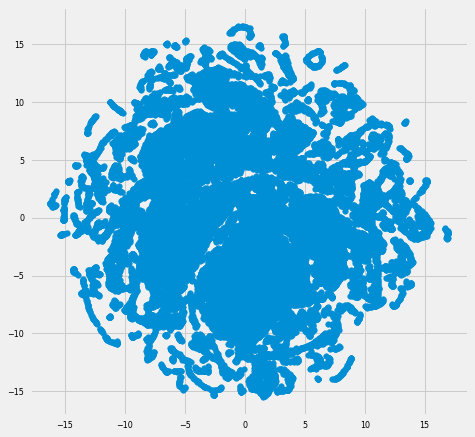

In [334]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.5,
                      metric='correlation').fit_transform(xtrain[features[:5]])
plt.scatter(embedding[:, 0], embedding[:, 1])

In [335]:
x_reduced = xtrain.drop(features[:5], axis = 1)
                            
x_reduced =  np.concatenate([x_reduced, embedding], axis = 1)

lg_score = cross_val_score(rf, x_reduced, ytrain, cv=skf, scoring='roc_auc').mean()
print(f"RandomForest score on reduced top 5 features {round(lg_score, 4)}, difff  + {round(lg_score - base_score, 4)}")

RandomForest score on reduced top 5 features 0.7348, difff  + 0.0007


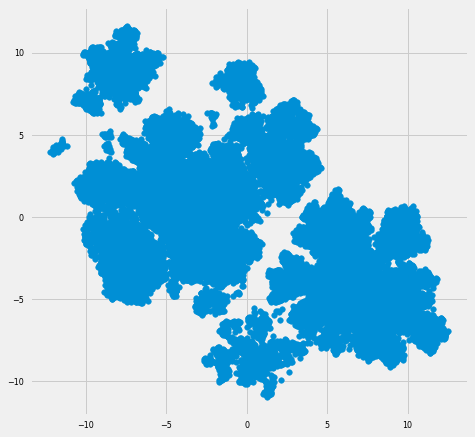

In [339]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.7,
                      metric='correlation').fit_transform(xtrain)
plt.scatter(embedding[:, 0], embedding[:, 1])

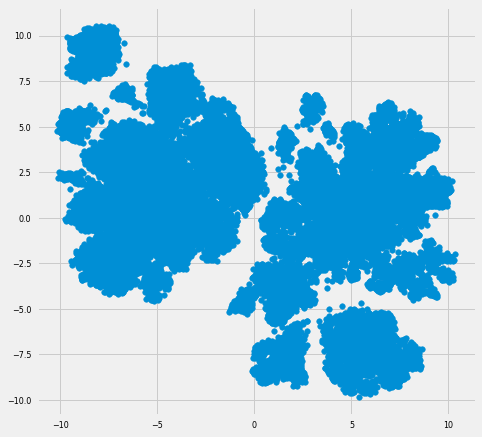

In [340]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.7,
                      metric='correlation').fit_transform(xtrain)
plt.scatter(embedding[:, 0], embedding[:, 1])

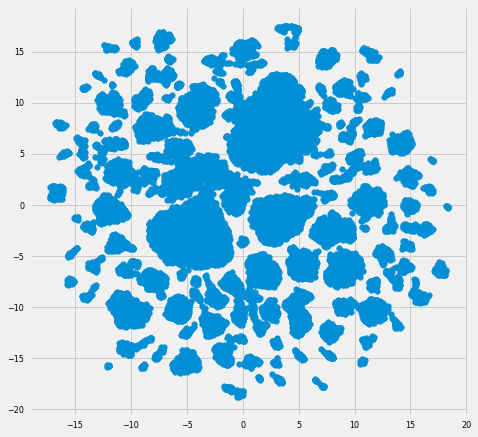

In [343]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.7,
                      metric='correlation').fit_transform(xtrain[cat_cols])
plt.scatter(embedding[:, 0], embedding[:, 1])

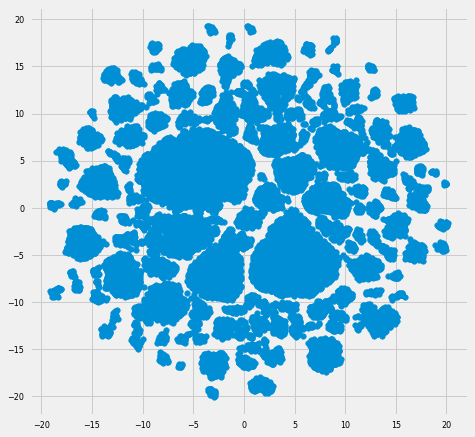

In [350]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.9,
                      metric='correlation').fit_transform(xtrain[cat_cols])
plt.scatter(embedding[:, 0], embedding[:, 1])

In [351]:
cat_embedding = embedding

In [346]:
cat_cols = [col for col in xtrain if xtrain[col].nunique() > 2  and xtrain[col].nunique() < 32]
bin_cols = [col for col in xtrain if xtrain[col].dropna().value_counts().index.isin([0,1]).all()]

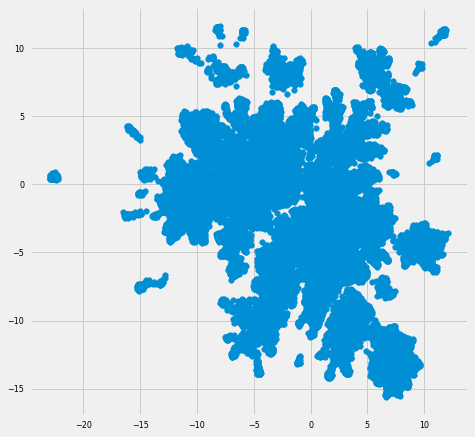

In [347]:
plt.rcParams['figure.figsize'] = 7, 7
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.7,
                      metric='correlation').fit_transform(xtrain[bin_cols])
plt.scatter(embedding[:, 0], embedding[:, 1])

In [348]:
bin_embedding = embedding

In [337]:

params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 8, 
    'num_leaves': 128, 
    'min_data_in_leaf' : 17
    
    }

n_rounds = 10000
lgb_train = lgb.Dataset(embedding, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(embedding, ytrain), 
                early_stopping_rounds=100, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.552528 + 0.0132938
[2]	cv_agg's auc: 0.640584 + 0.0105456
[3]	cv_agg's auc: 0.631062 + 0.0108204
[4]	cv_agg's auc: 0.641847 + 0.0100241
[5]	cv_agg's auc: 0.637741 + 0.00952751
[6]	cv_agg's auc: 0.643111 + 0.0104158
[7]	cv_agg's auc: 0.640112 + 0.0102197
[8]	cv_agg's auc: 0.642629 + 0.0104311
[9]	cv_agg's auc: 0.640796 + 0.0103215
[10]	cv_agg's auc: 0.643128 + 0.010212
[11]	cv_agg's auc: 0.641885 + 0.0102236
[12]	cv_agg's auc: 0.643735 + 0.0104463
[13]	cv_agg's auc: 0.642461 + 0.0103912
[14]	cv_agg's auc: 0.643873 + 0.0105112
[15]	cv_agg's auc: 0.642735 + 0.0103811
[16]	cv_agg's auc: 0.64389 + 0.0103553
[17]	cv_agg's auc: 0.643195 + 0.0104248
[18]	cv_agg's auc: 0.644153 + 0.0103518
[19]	cv_agg's auc: 0.643376 + 0.0102861
[20]	cv_agg's auc: 0.64421 + 0.0103401
[21]	cv_agg's auc: 0.643524 + 0.0101009
[22]	cv_agg's auc: 0.644237 + 0.0102197
[23]	cv_agg's auc: 0.643632 + 0.0100582
[24]	cv_agg's auc: 0.64438 + 0.0101208
[25]	cv_agg's auc: 0.64391 + 0.0100723
[26]	cv_agg's

[205]	cv_agg's auc: 0.646833 + 0.0108911
[206]	cv_agg's auc: 0.64689 + 0.0108744
[207]	cv_agg's auc: 0.646834 + 0.0108931
[208]	cv_agg's auc: 0.646852 + 0.0109093
[209]	cv_agg's auc: 0.646827 + 0.0108988
[210]	cv_agg's auc: 0.64687 + 0.0109054
[211]	cv_agg's auc: 0.646833 + 0.0109057
[212]	cv_agg's auc: 0.646906 + 0.0109106
[213]	cv_agg's auc: 0.646885 + 0.0108735
[214]	cv_agg's auc: 0.646945 + 0.0108659
[215]	cv_agg's auc: 0.646915 + 0.0109062
[216]	cv_agg's auc: 0.646955 + 0.0108978
[217]	cv_agg's auc: 0.646897 + 0.0109318
[218]	cv_agg's auc: 0.646951 + 0.0109484
[219]	cv_agg's auc: 0.646866 + 0.0109629
[220]	cv_agg's auc: 0.646936 + 0.0109547
[221]	cv_agg's auc: 0.646904 + 0.0109576
[222]	cv_agg's auc: 0.646974 + 0.0109708
[223]	cv_agg's auc: 0.646949 + 0.010989
[224]	cv_agg's auc: 0.646964 + 0.0109879
[225]	cv_agg's auc: 0.646929 + 0.0109838
[226]	cv_agg's auc: 0.646949 + 0.0110038
[227]	cv_agg's auc: 0.646917 + 0.0109837
[228]	cv_agg's auc: 0.646944 + 0.010988
[229]	cv_agg's auc: 

[406]	cv_agg's auc: 0.647696 + 0.0112841
[407]	cv_agg's auc: 0.647686 + 0.0112822
[408]	cv_agg's auc: 0.647704 + 0.0112932
[409]	cv_agg's auc: 0.647673 + 0.0113152
[410]	cv_agg's auc: 0.647696 + 0.0113009
[411]	cv_agg's auc: 0.647676 + 0.0113198
[412]	cv_agg's auc: 0.647707 + 0.0113238
[413]	cv_agg's auc: 0.6477 + 0.011334
[414]	cv_agg's auc: 0.647708 + 0.0113303
[415]	cv_agg's auc: 0.647693 + 0.0113382
[416]	cv_agg's auc: 0.647729 + 0.0113311
[417]	cv_agg's auc: 0.647724 + 0.0113453
[418]	cv_agg's auc: 0.647723 + 0.0113305
[419]	cv_agg's auc: 0.647678 + 0.0113504
[420]	cv_agg's auc: 0.647668 + 0.0113677
[421]	cv_agg's auc: 0.647658 + 0.011381
[422]	cv_agg's auc: 0.647686 + 0.0113753
[423]	cv_agg's auc: 0.647672 + 0.011401
[424]	cv_agg's auc: 0.647685 + 0.0114034
[425]	cv_agg's auc: 0.647672 + 0.0114118
[426]	cv_agg's auc: 0.647695 + 0.0114111
[427]	cv_agg's auc: 0.647661 + 0.0114086
[428]	cv_agg's auc: 0.647678 + 0.0114035
[429]	cv_agg's auc: 0.647656 + 0.011414
[430]	cv_agg's auc: 0.

0.6477294600266654

In [338]:
embedding_all = embedding 

In [349]:
n_rounds = 10000
lgb_train = lgb.Dataset(embedding, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(bin_embedding, ytrain), 
                early_stopping_rounds=100, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.601495 + 0.00867457
[2]	cv_agg's auc: 0.614915 + 0.0112963
[3]	cv_agg's auc: 0.615036 + 0.0104153
[4]	cv_agg's auc: 0.615814 + 0.0123775
[5]	cv_agg's auc: 0.616735 + 0.0118777
[6]	cv_agg's auc: 0.616627 + 0.0117049
[7]	cv_agg's auc: 0.617662 + 0.0112282
[8]	cv_agg's auc: 0.617583 + 0.0112776
[9]	cv_agg's auc: 0.618304 + 0.0112182
[10]	cv_agg's auc: 0.61798 + 0.0116282
[11]	cv_agg's auc: 0.618494 + 0.0114277
[12]	cv_agg's auc: 0.617827 + 0.0115999
[13]	cv_agg's auc: 0.618472 + 0.0114925
[14]	cv_agg's auc: 0.618065 + 0.0116758
[15]	cv_agg's auc: 0.61847 + 0.0115727
[16]	cv_agg's auc: 0.618334 + 0.0118314
[17]	cv_agg's auc: 0.618904 + 0.0119631
[18]	cv_agg's auc: 0.618516 + 0.012255
[19]	cv_agg's auc: 0.619013 + 0.0121341
[20]	cv_agg's auc: 0.618684 + 0.0121678
[21]	cv_agg's auc: 0.618905 + 0.0120488
[22]	cv_agg's auc: 0.618677 + 0.0123953
[23]	cv_agg's auc: 0.618924 + 0.0124033
[24]	cv_agg's auc: 0.618527 + 0.0124728
[25]	cv_agg's auc: 0.618816 + 0.0124303
[26]	cv_agg

[205]	cv_agg's auc: 0.620378 + 0.0120109
[206]	cv_agg's auc: 0.620359 + 0.0120397
[207]	cv_agg's auc: 0.620363 + 0.0120605
[208]	cv_agg's auc: 0.62036 + 0.0120686
[209]	cv_agg's auc: 0.620337 + 0.0120627
[210]	cv_agg's auc: 0.620325 + 0.0120452
[211]	cv_agg's auc: 0.620342 + 0.0120183
[212]	cv_agg's auc: 0.620326 + 0.0120364
[213]	cv_agg's auc: 0.620358 + 0.0120337
[214]	cv_agg's auc: 0.62036 + 0.0120258
[215]	cv_agg's auc: 0.620378 + 0.0120195
[216]	cv_agg's auc: 0.620378 + 0.0120004
[217]	cv_agg's auc: 0.620354 + 0.0119883
[218]	cv_agg's auc: 0.620359 + 0.012004
[219]	cv_agg's auc: 0.62037 + 0.0119801
[220]	cv_agg's auc: 0.620348 + 0.011982
[221]	cv_agg's auc: 0.620382 + 0.0119818
[222]	cv_agg's auc: 0.62035 + 0.0119835
[223]	cv_agg's auc: 0.620338 + 0.0119796
[224]	cv_agg's auc: 0.620359 + 0.0119697
[225]	cv_agg's auc: 0.620341 + 0.0119546
[226]	cv_agg's auc: 0.620335 + 0.0119598
[227]	cv_agg's auc: 0.620325 + 0.0119531
[228]	cv_agg's auc: 0.620327 + 0.0119592
[229]	cv_agg's auc: 0.

0.6203817462203004

In [352]:
n_rounds = 10000
lgb_train = lgb.Dataset(embedding, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(cat_embedding, ytrain), 
                early_stopping_rounds=100, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.543632 + 0.00889015
[2]	cv_agg's auc: 0.548555 + 0.00706977
[3]	cv_agg's auc: 0.552023 + 0.00706723
[4]	cv_agg's auc: 0.548806 + 0.00597812
[5]	cv_agg's auc: 0.552054 + 0.00556577
[6]	cv_agg's auc: 0.550896 + 0.00593299
[7]	cv_agg's auc: 0.552236 + 0.00562023
[8]	cv_agg's auc: 0.551491 + 0.0055564
[9]	cv_agg's auc: 0.552374 + 0.00585671
[10]	cv_agg's auc: 0.55118 + 0.00551506
[11]	cv_agg's auc: 0.55241 + 0.005785
[12]	cv_agg's auc: 0.551832 + 0.00604303
[13]	cv_agg's auc: 0.552703 + 0.00623968
[14]	cv_agg's auc: 0.552143 + 0.00666882
[15]	cv_agg's auc: 0.552676 + 0.00711513
[16]	cv_agg's auc: 0.552565 + 0.00740241
[17]	cv_agg's auc: 0.552615 + 0.00738417
[18]	cv_agg's auc: 0.551857 + 0.00729351
[19]	cv_agg's auc: 0.55233 + 0.00695125
[20]	cv_agg's auc: 0.551951 + 0.00692488
[21]	cv_agg's auc: 0.552433 + 0.00682858
[22]	cv_agg's auc: 0.551941 + 0.00712626
[23]	cv_agg's auc: 0.552343 + 0.00724787
[24]	cv_agg's auc: 0.552088 + 0.00675479
[25]	cv_agg's auc: 0.552402 + 0

0.5527026916719102

####  4. Найдите категориальные переменные в вашем датасете (которые закодированные через LabelEncoding или OHE). Опишите как вы определили, что они категориальные. Закодируйте их через target. Укажите значение на кросс-валидации и LB. *

In [411]:
num_cols

['7',
 '92',
 '106',
 '107',
 '108',
 '117',
 '120',
 '124',
 '127',
 '212',
 '311',
 '312',
 '313',
 '314',
 '315',
 '341']

In [ ]:
92 =  90 mistce
108 = 100 mistce
124 = 83 mistce 
315 = 98 mistce
212 = 81 mistce

In [483]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(xtrn, ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)
results['test-auc-mean'].iloc[-1]
    

[0]	train-auc:0.701202+0.0050827	test-auc:0.667668+0.00400901
[1]	train-auc:0.731625+0.00419382	test-auc:0.690952+0.00605131
[2]	train-auc:0.743114+0.00295265	test-auc:0.699389+0.00591808
[3]	train-auc:0.747928+0.00431242	test-auc:0.703476+0.00322343
[4]	train-auc:0.752019+0.00461656	test-auc:0.706433+0.00450715
[5]	train-auc:0.754186+0.00587796	test-auc:0.708687+0.00361713
[6]	train-auc:0.755893+0.00612537	test-auc:0.709738+0.00367335
[7]	train-auc:0.758414+0.00583268	test-auc:0.71023+0.00429909
[8]	train-auc:0.760495+0.00568188	test-auc:0.710345+0.00500057
[9]	train-auc:0.762123+0.00488986	test-auc:0.711149+0.00460369
[10]	train-auc:0.762977+0.00456881	test-auc:0.711425+0.00380311
[11]	train-auc:0.76426+0.00493721	test-auc:0.712887+0.00288267
[12]	train-auc:0.764536+0.00490886	test-auc:0.713527+0.00293012
[13]	train-auc:0.765219+0.00424949	test-auc:0.714023+0.00341424
[14]	train-auc:0.766015+0.00369176	test-auc:0.714768+0.00366992
[15]	train-auc:0.766397+0.00422796	test-auc:0.71448+0

[129]	train-auc:0.810958+0.00423501	test-auc:0.727041+0.00446328
[130]	train-auc:0.811254+0.00423631	test-auc:0.727144+0.00444557
[131]	train-auc:0.81157+0.00432192	test-auc:0.727294+0.00442197
[132]	train-auc:0.812028+0.00434634	test-auc:0.727325+0.00442904
[133]	train-auc:0.812458+0.00420159	test-auc:0.727413+0.00441802
[134]	train-auc:0.812668+0.00417022	test-auc:0.727475+0.00444076
[135]	train-auc:0.812999+0.00409643	test-auc:0.727421+0.00455299
[136]	train-auc:0.813484+0.00393091	test-auc:0.727535+0.00456501
[137]	train-auc:0.813824+0.00399976	test-auc:0.727594+0.00464856
[138]	train-auc:0.814239+0.00386609	test-auc:0.727538+0.00471196
[139]	train-auc:0.81443+0.00390551	test-auc:0.727595+0.00464622
[140]	train-auc:0.814873+0.00396645	test-auc:0.727705+0.00467986
[141]	train-auc:0.815319+0.0039006	test-auc:0.727818+0.00469205
[142]	train-auc:0.815562+0.00387081	test-auc:0.727891+0.0046485
[143]	train-auc:0.815731+0.00401794	test-auc:0.727927+0.00464563
[144]	train-auc:0.816015+0.00

[256]	train-auc:0.854973+0.00188979	test-auc:0.735206+0.00571424
[257]	train-auc:0.855302+0.00195012	test-auc:0.735234+0.00571822
[258]	train-auc:0.855617+0.0019667	test-auc:0.735338+0.00576973
[259]	train-auc:0.855945+0.00187973	test-auc:0.735384+0.00574903
[260]	train-auc:0.856286+0.00187249	test-auc:0.735483+0.00573124
[261]	train-auc:0.856575+0.00179382	test-auc:0.735585+0.00572675
[262]	train-auc:0.856894+0.00180779	test-auc:0.735595+0.00571784
[263]	train-auc:0.857161+0.0018003	test-auc:0.735581+0.00572248
[264]	train-auc:0.857496+0.00178029	test-auc:0.735638+0.00572679
[265]	train-auc:0.857854+0.00176842	test-auc:0.735715+0.00574174
[266]	train-auc:0.858215+0.00170535	test-auc:0.735819+0.00570654
[267]	train-auc:0.858518+0.0017279	test-auc:0.735904+0.00570231
[268]	train-auc:0.858818+0.00175442	test-auc:0.735922+0.00571874
[269]	train-auc:0.859125+0.00180825	test-auc:0.735996+0.00574968
[270]	train-auc:0.859425+0.00180259	test-auc:0.736081+0.0056964
[271]	train-auc:0.859773+0.00

[383]	train-auc:0.888955+0.00164254	test-auc:0.739744+0.00543217
[384]	train-auc:0.889161+0.00168181	test-auc:0.739729+0.0054529
[385]	train-auc:0.889433+0.00174389	test-auc:0.739753+0.00545535
[386]	train-auc:0.889578+0.00180445	test-auc:0.739789+0.00542797
[387]	train-auc:0.889821+0.0018028	test-auc:0.739845+0.00542773
[388]	train-auc:0.890014+0.00177604	test-auc:0.739865+0.0053868
[389]	train-auc:0.890299+0.0017782	test-auc:0.739855+0.00539248
[390]	train-auc:0.890431+0.00174009	test-auc:0.739867+0.00539339
[391]	train-auc:0.8907+0.00175558	test-auc:0.73991+0.0054028
[392]	train-auc:0.890907+0.00169414	test-auc:0.739898+0.00539713
[393]	train-auc:0.891131+0.0017179	test-auc:0.739882+0.00542642
[394]	train-auc:0.891382+0.00176329	test-auc:0.739909+0.00545155
[395]	train-auc:0.891567+0.00179381	test-auc:0.739922+0.00546111
[396]	train-auc:0.891788+0.00180498	test-auc:0.73996+0.0054435
[397]	train-auc:0.891919+0.00185106	test-auc:0.739994+0.00542713
[398]	train-auc:0.892109+0.00190532	

[510]	train-auc:0.912702+0.00204342	test-auc:0.741607+0.00566699
[511]	train-auc:0.912864+0.00203604	test-auc:0.741614+0.00570364
[512]	train-auc:0.913063+0.0020077	test-auc:0.741602+0.00575409
[513]	train-auc:0.913182+0.0019893	test-auc:0.741603+0.00577746
[514]	train-auc:0.913344+0.00193016	test-auc:0.741605+0.00578065
[515]	train-auc:0.913449+0.00195653	test-auc:0.741602+0.00579026
[516]	train-auc:0.913584+0.00195562	test-auc:0.741622+0.00581802
[517]	train-auc:0.913736+0.00200299	test-auc:0.741619+0.00581284
[518]	train-auc:0.913896+0.00197068	test-auc:0.741646+0.00579985
[519]	train-auc:0.914025+0.00198887	test-auc:0.741643+0.00581225
[520]	train-auc:0.914247+0.00197891	test-auc:0.741665+0.00580394
[521]	train-auc:0.914439+0.00192997	test-auc:0.741666+0.00581909
[522]	train-auc:0.914579+0.00196993	test-auc:0.741685+0.00582328
[523]	train-auc:0.914834+0.00195643	test-auc:0.741755+0.00581921
[524]	train-auc:0.915037+0.00195221	test-auc:0.741759+0.00582674
[525]	train-auc:0.915156+0.

[638]	train-auc:0.931481+0.00181909	test-auc:0.742531+0.00597689
[639]	train-auc:0.931598+0.00182751	test-auc:0.742543+0.00599684
[640]	train-auc:0.931709+0.00177004	test-auc:0.742546+0.00598307
[641]	train-auc:0.931818+0.00177786	test-auc:0.742545+0.00597434
[642]	train-auc:0.931923+0.00177586	test-auc:0.742571+0.005986
[643]	train-auc:0.932021+0.00177779	test-auc:0.742582+0.00600781
[644]	train-auc:0.932172+0.00175521	test-auc:0.742621+0.0060017
[645]	train-auc:0.932328+0.00179509	test-auc:0.742658+0.00599113
[646]	train-auc:0.932468+0.00177126	test-auc:0.742653+0.00599084
[647]	train-auc:0.932575+0.00176847	test-auc:0.742653+0.00599925
[648]	train-auc:0.932718+0.00178047	test-auc:0.742679+0.00600073
[649]	train-auc:0.932875+0.00176461	test-auc:0.742678+0.00602698
[650]	train-auc:0.932965+0.00177868	test-auc:0.742655+0.00603493
[651]	train-auc:0.93309+0.00177393	test-auc:0.742639+0.00602159
[652]	train-auc:0.933233+0.00178749	test-auc:0.742687+0.00601918
[653]	train-auc:0.93338+0.001

[765]	train-auc:0.945794+0.00127904	test-auc:0.742982+0.00630186
[766]	train-auc:0.945915+0.00125386	test-auc:0.742992+0.00628946
[767]	train-auc:0.94603+0.0012232	test-auc:0.742966+0.00630996
[768]	train-auc:0.946136+0.00120811	test-auc:0.742951+0.0062878
[769]	train-auc:0.946215+0.00119158	test-auc:0.742945+0.00627822
[770]	train-auc:0.946318+0.00117619	test-auc:0.74293+0.0062748
[771]	train-auc:0.946397+0.00113622	test-auc:0.742929+0.00627718
[772]	train-auc:0.946488+0.00110075	test-auc:0.742942+0.00628296
[773]	train-auc:0.946582+0.00113442	test-auc:0.742932+0.00630458
[774]	train-auc:0.946675+0.00112605	test-auc:0.742896+0.00632317
[775]	train-auc:0.946772+0.00110481	test-auc:0.742868+0.00632818
[776]	train-auc:0.946876+0.0011299	test-auc:0.742826+0.0063359
[777]	train-auc:0.946993+0.00114044	test-auc:0.742817+0.0063414
[778]	train-auc:0.947097+0.00111127	test-auc:0.742787+0.00633099
[779]	train-auc:0.947211+0.00112591	test-auc:0.742769+0.00632725
[780]	train-auc:0.947295+0.001105

[892]	train-auc:0.95727+0.000981615	test-auc:0.742757+0.00627246
[893]	train-auc:0.957334+0.000980524	test-auc:0.742772+0.0062812
[894]	train-auc:0.957389+0.000978205	test-auc:0.742789+0.00625128
[895]	train-auc:0.957467+0.000952952	test-auc:0.742798+0.0062599
[896]	train-auc:0.957533+0.000961855	test-auc:0.74278+0.00625586
[897]	train-auc:0.957623+0.00096567	test-auc:0.742765+0.00625325
[898]	train-auc:0.957677+0.000974628	test-auc:0.74274+0.00623261
[899]	train-auc:0.957756+0.000959585	test-auc:0.742732+0.00625109
[900]	train-auc:0.957844+0.000941417	test-auc:0.742732+0.00622182
[901]	train-auc:0.957892+0.000939578	test-auc:0.742729+0.0062224


0.7430643333333333

In [474]:
xgb_model = xgb.train(params_xgb, xgb_train, len(results))

In [475]:
import xgbfir
xgbfir.saveXgbFI(xgb_model)

In [480]:
xtrnn = xtrn.copy()
xtrnn['7_91'] = np.sqrt( xgtrain['339'] * xgtrain['34'] )

xtrnn.drop(['91'], axis=1, inplace=True)


In [471]:
xtrn = xgtrain.copy()
xtrn['339_34'] = np.sqrt( xgtrain['339'] * xgtrain['34'] )

xtrn.drop(['34'], axis=1, inplace=True)


In [484]:
xtsn = xgtest.copy()
xtsn['339_34'] = np.sqrt( xgtest['339'] * xgtest['34'] )

xtsn.drop(['34'], axis=1, inplace=True)


In [492]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.03,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(xtrn, ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)
results['test-auc-mean'].iloc[-1]
    

[0]	train-auc:0.701202+0.0050827	test-auc:0.667668+0.00400901
[1]	train-auc:0.731913+0.0040308	test-auc:0.691261+0.00640453
[2]	train-auc:0.74397+0.0027811	test-auc:0.700509+0.00654601
[3]	train-auc:0.747993+0.00471308	test-auc:0.703872+0.00406308
[4]	train-auc:0.753144+0.0048201	test-auc:0.70714+0.0041634
[5]	train-auc:0.755744+0.00584959	test-auc:0.709735+0.00286579
[6]	train-auc:0.75876+0.00611556	test-auc:0.711194+0.00218333
[7]	train-auc:0.761775+0.00578103	test-auc:0.711684+0.00329766
[8]	train-auc:0.765029+0.00546543	test-auc:0.711947+0.00509108
[9]	train-auc:0.767602+0.00426946	test-auc:0.712534+0.00421355
[10]	train-auc:0.769592+0.00355671	test-auc:0.713298+0.00422665
[11]	train-auc:0.771671+0.00433901	test-auc:0.714517+0.00252304
[12]	train-auc:0.772373+0.00422365	test-auc:0.715097+0.00266269
[13]	train-auc:0.774008+0.00393671	test-auc:0.715915+0.0031201
[14]	train-auc:0.775544+0.00336626	test-auc:0.716588+0.00310923
[15]	train-auc:0.776494+0.00364535	test-auc:0.716915+0.0032

[129]	train-auc:0.887548+0.00179007	test-auc:0.73788+0.00407398
[130]	train-auc:0.888189+0.00174018	test-auc:0.737983+0.00407084
[131]	train-auc:0.888831+0.00170417	test-auc:0.738127+0.00409773
[132]	train-auc:0.889404+0.00185944	test-auc:0.738237+0.00418485
[133]	train-auc:0.890015+0.00168656	test-auc:0.738312+0.00422629
[134]	train-auc:0.890559+0.00155519	test-auc:0.738449+0.00419385
[135]	train-auc:0.8912+0.00161284	test-auc:0.738525+0.00423646
[136]	train-auc:0.891712+0.00158893	test-auc:0.738646+0.00426993
[137]	train-auc:0.892007+0.00162897	test-auc:0.738565+0.00428183
[138]	train-auc:0.892395+0.00164936	test-auc:0.738636+0.00438313
[139]	train-auc:0.892926+0.00182679	test-auc:0.738642+0.00449647
[140]	train-auc:0.893676+0.00190318	test-auc:0.738631+0.0045413
[141]	train-auc:0.894262+0.00198145	test-auc:0.738669+0.00463454
[142]	train-auc:0.894865+0.00186713	test-auc:0.738588+0.00469566
[143]	train-auc:0.895517+0.00197342	test-auc:0.738528+0.00473911
[144]	train-auc:0.896167+0.00

[256]	train-auc:0.943369+0.00119168	test-auc:0.7402+0.00620301
[257]	train-auc:0.943668+0.00114592	test-auc:0.740214+0.00623604
[258]	train-auc:0.944043+0.00119629	test-auc:0.740185+0.00633922
[259]	train-auc:0.944352+0.00111677	test-auc:0.740217+0.00632034
[260]	train-auc:0.944694+0.00115227	test-auc:0.740171+0.00631078
[261]	train-auc:0.944965+0.00127662	test-auc:0.740074+0.00629464
[262]	train-auc:0.945136+0.00129411	test-auc:0.740085+0.00629733
[263]	train-auc:0.945313+0.00126178	test-auc:0.740035+0.0063221
[264]	train-auc:0.945661+0.00124016	test-auc:0.739978+0.00638487
[265]	train-auc:0.945996+0.00111377	test-auc:0.739991+0.0064127
[266]	train-auc:0.946381+0.00109555	test-auc:0.73997+0.00637584
[267]	train-auc:0.946801+0.0012118	test-auc:0.739893+0.0064881
[268]	train-auc:0.947192+0.00125844	test-auc:0.73981+0.00644498
[269]	train-auc:0.947406+0.00121315	test-auc:0.739778+0.00651328
[270]	train-auc:0.947691+0.00132575	test-auc:0.739766+0.00657666
[271]	train-auc:0.948091+0.001322

[383]	train-auc:0.971955+0.00110476	test-auc:0.739209+0.00720734
[384]	train-auc:0.972052+0.00111093	test-auc:0.739198+0.00720967


0.7405223333333333

In [493]:
ks = np.arange(100, 330, 10)
k_scores = []
rf_scores = []
xgb_scores = []
lgb_scores = []

params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.03,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}
n_rounds = 10000
for k in ks:
    print(k, end = " ")
    x_data_kbest = SelectKBest(f_classif, k=k).fit_transform(xtrn, ytrain)
    
    xgb_train = xgb.DMatrix(x_data_kbest, ytrain)
    results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=100, verbose_eval=0)
    lol = results['test-auc-mean'].iloc[-1]
    print(lol)
    xgb_scores.append(lol)
    

100 0.739061
110 0.7380173333333332
120 0.737502
130 0.7385366666666666
140 0.739545
150 0.737955
160 0.7404356666666666
170 0.7410886666666666
180 0.7403863333333334
190 0.7407983333333333
200 0.740922
210 0.7408239999999999
220 0.740042
230 0.7401783333333333
240 0.7410100000000001
250 0.74051
260 0.7404780000000001
270 0.739454
280 0.7407513333333333
290 0.7406333333333333
300 0.7402343333333333
310 0.7407766666666666
320 0.741168


In [494]:
np.max(xgb_scores)

0.741168

In [497]:
x_data_kbest = SelectKBest(f_classif, k=320).fit_transform(xtrn, ytrain)
xgb_train = xgb.DMatrix(x_data_kbest, ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)
results['test-auc-mean'].iloc[-1]


[0]	train-auc:0.707135+0.0041715	test-auc:0.664944+0.00648949
[1]	train-auc:0.73424+0.00243652	test-auc:0.692099+0.0076568
[2]	train-auc:0.744047+0.00212611	test-auc:0.697527+0.00281013
[3]	train-auc:0.75017+0.00221469	test-auc:0.701647+0.0014473
[4]	train-auc:0.754481+0.00269754	test-auc:0.702563+0.00267192
[5]	train-auc:0.758583+0.00324938	test-auc:0.705782+0.00324084
[6]	train-auc:0.761059+0.00424848	test-auc:0.707349+0.00229906
[7]	train-auc:0.763495+0.00366052	test-auc:0.708868+0.00161109
[8]	train-auc:0.764751+0.00389823	test-auc:0.709907+0.00117686
[9]	train-auc:0.764848+0.00432655	test-auc:0.710284+0.00229641
[10]	train-auc:0.765491+0.00427005	test-auc:0.71103+0.0025618
[11]	train-auc:0.767061+0.00469558	test-auc:0.711475+0.00250218
[12]	train-auc:0.767479+0.00444996	test-auc:0.711651+0.00265839
[13]	train-auc:0.768363+0.00505854	test-auc:0.712237+0.00266064
[14]	train-auc:0.768982+0.00499805	test-auc:0.712508+0.00204095
[15]	train-auc:0.769618+0.00456291	test-auc:0.712515+0.00

[129]	train-auc:0.811863+0.0029818	test-auc:0.727529+0.00395596
[130]	train-auc:0.812209+0.00297207	test-auc:0.727564+0.00396691
[131]	train-auc:0.812527+0.0029123	test-auc:0.72769+0.0039729
[132]	train-auc:0.812892+0.00285293	test-auc:0.727797+0.00404155
[133]	train-auc:0.813375+0.00298674	test-auc:0.727922+0.00408475
[134]	train-auc:0.813796+0.00294569	test-auc:0.72797+0.00418606
[135]	train-auc:0.814064+0.00290433	test-auc:0.728048+0.00415808
[136]	train-auc:0.814408+0.00298798	test-auc:0.728014+0.00412027
[137]	train-auc:0.814645+0.00292913	test-auc:0.728081+0.00406267
[138]	train-auc:0.815042+0.00270507	test-auc:0.728159+0.00417106
[139]	train-auc:0.815439+0.00265709	test-auc:0.728221+0.0042002
[140]	train-auc:0.815847+0.00278667	test-auc:0.728321+0.00418332
[141]	train-auc:0.816141+0.00277976	test-auc:0.728359+0.00413132
[142]	train-auc:0.816569+0.00272103	test-auc:0.728483+0.00413999
[143]	train-auc:0.817036+0.00283105	test-auc:0.728527+0.00412973
[144]	train-auc:0.817399+0.0028

[256]	train-auc:0.854723+0.00195587	test-auc:0.735375+0.00531453
[257]	train-auc:0.855007+0.00198345	test-auc:0.735489+0.00535609
[258]	train-auc:0.855347+0.00200471	test-auc:0.735569+0.00528874
[259]	train-auc:0.85564+0.00198144	test-auc:0.73562+0.00529355
[260]	train-auc:0.855934+0.00196337	test-auc:0.735673+0.00533296
[261]	train-auc:0.856245+0.00192834	test-auc:0.735696+0.00530744
[262]	train-auc:0.856579+0.00181662	test-auc:0.735732+0.00535292
[263]	train-auc:0.85692+0.00178015	test-auc:0.735807+0.00535428
[264]	train-auc:0.857245+0.00178743	test-auc:0.735883+0.00537844
[265]	train-auc:0.857551+0.00181232	test-auc:0.735907+0.00541811
[266]	train-auc:0.857866+0.00183971	test-auc:0.735995+0.00537416
[267]	train-auc:0.858153+0.00181016	test-auc:0.736058+0.00536245
[268]	train-auc:0.858476+0.00181102	test-auc:0.736129+0.00537705
[269]	train-auc:0.858738+0.0018358	test-auc:0.736172+0.00541248
[270]	train-auc:0.85905+0.00178823	test-auc:0.736242+0.00543554
[271]	train-auc:0.859323+0.001

[384]	train-auc:0.888842+0.00187451	test-auc:0.739955+0.00603556
[385]	train-auc:0.889076+0.00186311	test-auc:0.73998+0.00603886
[386]	train-auc:0.889285+0.00189798	test-auc:0.739997+0.00605931
[387]	train-auc:0.889502+0.00190029	test-auc:0.740057+0.00607104
[388]	train-auc:0.889727+0.00185268	test-auc:0.740063+0.00609482
[389]	train-auc:0.890001+0.00186079	test-auc:0.740055+0.00610461
[390]	train-auc:0.890223+0.00187493	test-auc:0.740074+0.00608239
[391]	train-auc:0.890499+0.00191295	test-auc:0.740096+0.00608033
[392]	train-auc:0.890656+0.00197896	test-auc:0.740124+0.00608249
[393]	train-auc:0.890849+0.00196439	test-auc:0.740123+0.00608672
[394]	train-auc:0.891073+0.00196429	test-auc:0.74015+0.00613104
[395]	train-auc:0.891267+0.00192231	test-auc:0.740164+0.00613885
[396]	train-auc:0.891531+0.00185641	test-auc:0.740174+0.00621111
[397]	train-auc:0.891758+0.00183777	test-auc:0.740183+0.0062184
[398]	train-auc:0.891948+0.00184899	test-auc:0.740208+0.00617805
[399]	train-auc:0.892216+0.0

[511]	train-auc:0.912813+0.00164842	test-auc:0.742043+0.0066172
[512]	train-auc:0.913017+0.00161944	test-auc:0.742044+0.00661348
[513]	train-auc:0.913164+0.00165892	test-auc:0.74206+0.00659854
[514]	train-auc:0.91337+0.00162822	test-auc:0.742058+0.00661937
[515]	train-auc:0.913523+0.00164605	test-auc:0.742029+0.00662944
[516]	train-auc:0.913681+0.00167143	test-auc:0.742065+0.00664961
[517]	train-auc:0.913827+0.00167972	test-auc:0.742086+0.00667857
[518]	train-auc:0.913965+0.00171832	test-auc:0.74207+0.00668357
[519]	train-auc:0.914109+0.00176114	test-auc:0.742043+0.00670083
[520]	train-auc:0.914241+0.00180718	test-auc:0.742051+0.00670993
[521]	train-auc:0.914427+0.00173305	test-auc:0.742065+0.00672129
[522]	train-auc:0.91455+0.00172235	test-auc:0.742101+0.00674765
[523]	train-auc:0.91474+0.00173872	test-auc:0.742108+0.0067392
[524]	train-auc:0.914898+0.00173087	test-auc:0.742111+0.00672834
[525]	train-auc:0.915112+0.00170601	test-auc:0.74212+0.00672159
[526]	train-auc:0.915244+0.001741

[638]	train-auc:0.931002+0.0014107	test-auc:0.742774+0.00663061
[639]	train-auc:0.931127+0.00142689	test-auc:0.742772+0.00662071
[640]	train-auc:0.931209+0.00145859	test-auc:0.742769+0.00661081
[641]	train-auc:0.931324+0.0014643	test-auc:0.742796+0.00661103
[642]	train-auc:0.931428+0.00144412	test-auc:0.742787+0.00662835
[643]	train-auc:0.931563+0.00147076	test-auc:0.742775+0.00663165
[644]	train-auc:0.931732+0.00147814	test-auc:0.742781+0.00661645
[645]	train-auc:0.931819+0.00148514	test-auc:0.74277+0.00660692
[646]	train-auc:0.931917+0.0015295	test-auc:0.742768+0.00658909
[647]	train-auc:0.931996+0.00155543	test-auc:0.742785+0.00657409
[648]	train-auc:0.932163+0.00156629	test-auc:0.742796+0.00659587
[649]	train-auc:0.932303+0.00158343	test-auc:0.742753+0.00657326
[650]	train-auc:0.932409+0.00157569	test-auc:0.742741+0.00656997
[651]	train-auc:0.932495+0.00160385	test-auc:0.742752+0.00658563
[652]	train-auc:0.932626+0.0015971	test-auc:0.742737+0.00655801
[653]	train-auc:0.932732+0.001

[765]	train-auc:0.945534+0.00103695	test-auc:0.742991+0.0069546
[766]	train-auc:0.945642+0.000995934	test-auc:0.742998+0.00696982
[767]	train-auc:0.945751+0.000965348	test-auc:0.743009+0.00696029
[768]	train-auc:0.945853+0.00101952	test-auc:0.743007+0.00696646
[769]	train-auc:0.945974+0.00099269	test-auc:0.743013+0.00698725
[770]	train-auc:0.946092+0.00102989	test-auc:0.743029+0.00699758
[771]	train-auc:0.946189+0.000995143	test-auc:0.74302+0.00696822
[772]	train-auc:0.946284+0.00100977	test-auc:0.743034+0.00698017
[773]	train-auc:0.946434+0.000996336	test-auc:0.74304+0.00695506
[774]	train-auc:0.946516+0.00100379	test-auc:0.743026+0.00695523
[775]	train-auc:0.946586+0.00100637	test-auc:0.743013+0.0069623
[776]	train-auc:0.946687+0.00100601	test-auc:0.743018+0.00697246
[777]	train-auc:0.946776+0.00104722	test-auc:0.743026+0.00696831
[778]	train-auc:0.946887+0.00104389	test-auc:0.74302+0.00695949
[779]	train-auc:0.946999+0.00101762	test-auc:0.743005+0.00696384
[780]	train-auc:0.947112+0

[891]	train-auc:0.956988+0.000995155	test-auc:0.74303+0.006686
[892]	train-auc:0.957075+0.000977054	test-auc:0.743037+0.00665886
[893]	train-auc:0.957154+0.000986639	test-auc:0.743018+0.00665323
[894]	train-auc:0.957236+0.000994643	test-auc:0.743004+0.00664351
[895]	train-auc:0.957314+0.000972176	test-auc:0.742994+0.00664236
[896]	train-auc:0.957365+0.000986978	test-auc:0.742992+0.00665026
[897]	train-auc:0.957442+0.00096753	test-auc:0.742988+0.0066638
[898]	train-auc:0.957495+0.000976913	test-auc:0.742998+0.00666908
[899]	train-auc:0.957571+0.000986601	test-auc:0.743003+0.006703
[900]	train-auc:0.957652+0.000975084	test-auc:0.743004+0.00671633
[901]	train-auc:0.957707+0.000959585	test-auc:0.742992+0.00671237
[902]	train-auc:0.95774+0.000961899	test-auc:0.742984+0.00672685
[903]	train-auc:0.957794+0.000955094	test-auc:0.743018+0.00671705
[904]	train-auc:0.957847+0.000966703	test-auc:0.743013+0.00671871
[905]	train-auc:0.957887+0.000974155	test-auc:0.743007+0.0067063
[906]	train-auc:0.9

[1017]	train-auc:0.965479+0.000874254	test-auc:0.742647+0.00676562
[1018]	train-auc:0.96555+0.000844557	test-auc:0.742661+0.00675707
[1019]	train-auc:0.965622+0.000856805	test-auc:0.742648+0.00671654
[1020]	train-auc:0.965673+0.000866528	test-auc:0.742646+0.0067174


0.7431770000000001

In [505]:
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
xgbfir.saveXgbFI(xgb_model)

In [511]:
xtrnn = x_data_kbest.copy()

# xtrnn.drop([], axis=1, inplace=True)


In [ ]:
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
xgbfir.saveXgbFI(xgb_model)

In [485]:
xgb_test= xgb.DMatrix(xtsn)
xgb_model = xgb.train(params_xgb, xgb_train, len(results))
lol_xgb_predictions = xgb_model.predict(xgb_test)

In [486]:
def to_submission(predictions, filename):
    seria = pd.Series(predictions, name='_VAL_')
    seria.to_csv(filename, header=True, index_label='_ID_')

In [ ]:
xgboost statistics 
0.7420459999999999 - base
0.7424143333333334 - remove 
0.7427796666666667 - my remove 0he i td 
0.7430643333333333 - 339 - 34 
0.7431770000000001 - + 320 best 

In [627]:
params_xgb = {
   
    'objective': 'binary:logistic',
    'eta': 0.01,
    'silent': 1,
    "nthread": 4,
    "random_seed": 17,
    "eval_metric": 'auc',
   
    
    'max_depth':  8,
    'max_leaves': 75,
    'subsample': 0.85, 
    'colsample_bytree': 0.66,

    'tree_method': 'hist',
    'grow_policy': 'lossguide'
   
}

xgb_train = xgb.DMatrix(xtrain.astype(float), ytrain)
results = xgb.cv(params_xgb, xgb_train, num_boost_round=n_rounds, folds=skf, early_stopping_rounds=150, verbose_eval=1)
results['test-auc-mean'].iloc[-1]
    

[0]	train-auc:0.71268+0.00692719	test-auc:0.673044+0.0070593
[1]	train-auc:0.738419+0.00542424	test-auc:0.695339+0.00428672
[2]	train-auc:0.744912+0.00536753	test-auc:0.698944+0.00448138
[3]	train-auc:0.748717+0.00533202	test-auc:0.701979+0.00507496
[4]	train-auc:0.756143+0.00430288	test-auc:0.705472+0.00473825
[5]	train-auc:0.75795+0.0045295	test-auc:0.707209+0.00602391
[6]	train-auc:0.759782+0.00390986	test-auc:0.708094+0.00447251
[7]	train-auc:0.76043+0.0040129	test-auc:0.709588+0.00436313
[8]	train-auc:0.761076+0.00468144	test-auc:0.709389+0.00575544
[9]	train-auc:0.763891+0.00482866	test-auc:0.711285+0.00547552
[10]	train-auc:0.765016+0.00493865	test-auc:0.711129+0.00458951
[11]	train-auc:0.765224+0.00531576	test-auc:0.711307+0.0050091
[12]	train-auc:0.765641+0.0051413	test-auc:0.711953+0.00505108
[13]	train-auc:0.766271+0.00503503	test-auc:0.712725+0.00491208
[14]	train-auc:0.766778+0.00511312	test-auc:0.713319+0.0051946
[15]	train-auc:0.767369+0.00550408	test-auc:0.713038+0.0051

[129]	train-auc:0.812587+0.00370131	test-auc:0.726608+0.00507963
[130]	train-auc:0.81284+0.00366159	test-auc:0.726729+0.00512541
[131]	train-auc:0.813089+0.00370359	test-auc:0.72682+0.00515932
[132]	train-auc:0.813628+0.00362075	test-auc:0.726905+0.00510355
[133]	train-auc:0.813934+0.0035996	test-auc:0.727107+0.00505809
[134]	train-auc:0.81435+0.00373038	test-auc:0.727292+0.00507371
[135]	train-auc:0.814582+0.003795	test-auc:0.727384+0.00495703
[136]	train-auc:0.814868+0.00382906	test-auc:0.727397+0.00495193
[137]	train-auc:0.815122+0.0038707	test-auc:0.727494+0.00493335
[138]	train-auc:0.815546+0.00376083	test-auc:0.727582+0.00487829
[139]	train-auc:0.815751+0.00383609	test-auc:0.727695+0.00486137
[140]	train-auc:0.816303+0.00380131	test-auc:0.727854+0.00493829
[141]	train-auc:0.816709+0.0038954	test-auc:0.727894+0.00488677
[142]	train-auc:0.817075+0.00367634	test-auc:0.727968+0.00486111
[143]	train-auc:0.817449+0.00359855	test-auc:0.728031+0.00485556
[144]	train-auc:0.817779+0.003596

[256]	train-auc:0.855825+0.00176999	test-auc:0.735313+0.00522622
[257]	train-auc:0.856122+0.00179699	test-auc:0.735354+0.00521685
[258]	train-auc:0.856422+0.0018259	test-auc:0.735461+0.00516223
[259]	train-auc:0.856753+0.00178834	test-auc:0.735512+0.0051788
[260]	train-auc:0.857073+0.0017444	test-auc:0.73558+0.00516703
[261]	train-auc:0.857451+0.00169074	test-auc:0.735674+0.00514594
[262]	train-auc:0.857729+0.00170086	test-auc:0.735754+0.00516955
[263]	train-auc:0.85806+0.00168686	test-auc:0.735835+0.00520961
[264]	train-auc:0.858362+0.00167699	test-auc:0.735838+0.0052272
[265]	train-auc:0.858708+0.00159744	test-auc:0.735838+0.0052509
[266]	train-auc:0.859028+0.00161182	test-auc:0.735871+0.00525873
[267]	train-auc:0.859365+0.00159376	test-auc:0.735888+0.00526647
[268]	train-auc:0.859625+0.00160654	test-auc:0.735929+0.0053114
[269]	train-auc:0.859976+0.00160121	test-auc:0.735955+0.0052766
[270]	train-auc:0.860299+0.00160752	test-auc:0.736013+0.00527702
[271]	train-auc:0.860546+0.0016383

[383]	train-auc:0.889177+0.00154845	test-auc:0.739604+0.00541945
[384]	train-auc:0.889447+0.00160266	test-auc:0.739654+0.00540407
[385]	train-auc:0.889648+0.00156689	test-auc:0.739705+0.00539012
[386]	train-auc:0.889905+0.00154951	test-auc:0.739701+0.00538013
[387]	train-auc:0.890126+0.0015642	test-auc:0.739718+0.00543244
[388]	train-auc:0.890289+0.00157066	test-auc:0.73974+0.0054294
[389]	train-auc:0.890496+0.00156693	test-auc:0.739776+0.00545696
[390]	train-auc:0.890759+0.00150562	test-auc:0.739766+0.00543998
[391]	train-auc:0.890946+0.00147111	test-auc:0.739763+0.00545946
[392]	train-auc:0.891138+0.00148856	test-auc:0.739768+0.00548681
[393]	train-auc:0.891345+0.00152023	test-auc:0.739724+0.00544285
[394]	train-auc:0.891558+0.00146922	test-auc:0.739725+0.00547636
[395]	train-auc:0.891742+0.00140396	test-auc:0.739724+0.00549109
[396]	train-auc:0.891956+0.00140751	test-auc:0.739742+0.00549319
[397]	train-auc:0.892197+0.00136139	test-auc:0.739779+0.00550873
[398]	train-auc:0.892423+0.0

[510]	train-auc:0.913671+0.00143403	test-auc:0.741454+0.00618881
[511]	train-auc:0.913761+0.00142916	test-auc:0.741465+0.00618373
[512]	train-auc:0.913998+0.00139058	test-auc:0.741475+0.00614969
[513]	train-auc:0.914125+0.00139792	test-auc:0.741461+0.00616812
[514]	train-auc:0.914263+0.00136091	test-auc:0.741443+0.00615552
[515]	train-auc:0.914494+0.00135107	test-auc:0.74147+0.00616084
[516]	train-auc:0.914696+0.00131947	test-auc:0.741453+0.00618806
[517]	train-auc:0.914833+0.00130026	test-auc:0.741462+0.00622431
[518]	train-auc:0.914959+0.00128645	test-auc:0.741466+0.00626789
[519]	train-auc:0.915154+0.00123088	test-auc:0.74149+0.00625865
[520]	train-auc:0.9153+0.00122423	test-auc:0.741503+0.00626896
[521]	train-auc:0.915433+0.00126103	test-auc:0.741531+0.0062613
[522]	train-auc:0.915596+0.00119445	test-auc:0.741541+0.00630491
[523]	train-auc:0.91574+0.0012134	test-auc:0.741529+0.00628016
[524]	train-auc:0.915907+0.00124216	test-auc:0.741559+0.0062481
[525]	train-auc:0.916027+0.001233

[637]	train-auc:0.931299+0.00113579	test-auc:0.742089+0.00662993
[638]	train-auc:0.931396+0.00113733	test-auc:0.742076+0.00663836
[639]	train-auc:0.931526+0.00111498	test-auc:0.742041+0.00665012
[640]	train-auc:0.931662+0.00113999	test-auc:0.742089+0.0066652
[641]	train-auc:0.931796+0.00108514	test-auc:0.74209+0.00665644
[642]	train-auc:0.931949+0.00107608	test-auc:0.742126+0.0066498
[643]	train-auc:0.932119+0.0010924	test-auc:0.742102+0.00662439
[644]	train-auc:0.932243+0.00115268	test-auc:0.742099+0.00662549
[645]	train-auc:0.932301+0.00117396	test-auc:0.742108+0.00665619
[646]	train-auc:0.932428+0.00115889	test-auc:0.742118+0.00663651
[647]	train-auc:0.932565+0.00121312	test-auc:0.742118+0.00663543
[648]	train-auc:0.932697+0.00115809	test-auc:0.742129+0.0066277
[649]	train-auc:0.932879+0.00115971	test-auc:0.742163+0.00661036
[650]	train-auc:0.933052+0.00115569	test-auc:0.742216+0.00662213
[651]	train-auc:0.933191+0.00122604	test-auc:0.742232+0.00664578
[652]	train-auc:0.933263+0.001

[764]	train-auc:0.945661+0.00102476	test-auc:0.742322+0.0069018
[765]	train-auc:0.945759+0.00105394	test-auc:0.742309+0.00689194
[766]	train-auc:0.945863+0.00105211	test-auc:0.742309+0.00688685
[767]	train-auc:0.945977+0.0011045	test-auc:0.742323+0.00690085
[768]	train-auc:0.946076+0.00108147	test-auc:0.742328+0.00689454
[769]	train-auc:0.946159+0.0010634	test-auc:0.742351+0.00690298
[770]	train-auc:0.94626+0.0010573	test-auc:0.742384+0.00689729
[771]	train-auc:0.946351+0.00108108	test-auc:0.742372+0.00692079
[772]	train-auc:0.946443+0.00104327	test-auc:0.742381+0.00693791
[773]	train-auc:0.946538+0.00102723	test-auc:0.742361+0.00691981
[774]	train-auc:0.946628+0.00104643	test-auc:0.742356+0.00696105
[775]	train-auc:0.946771+0.00101442	test-auc:0.742355+0.00696187
[776]	train-auc:0.946876+0.00103913	test-auc:0.742344+0.00697219
[777]	train-auc:0.94699+0.00104173	test-auc:0.742331+0.0069924
[778]	train-auc:0.947077+0.00104914	test-auc:0.742333+0.00699273
[779]	train-auc:0.947131+0.00106

[891]	train-auc:0.956819+0.00113155	test-auc:0.742365+0.00694918
[892]	train-auc:0.95689+0.00113899	test-auc:0.742329+0.00694557
[893]	train-auc:0.956983+0.00114704	test-auc:0.742317+0.00695152
[894]	train-auc:0.957077+0.00112762	test-auc:0.742312+0.00694395
[895]	train-auc:0.957187+0.00112545	test-auc:0.742266+0.00695036
[896]	train-auc:0.957278+0.00113626	test-auc:0.742262+0.00697444
[897]	train-auc:0.95734+0.00114756	test-auc:0.742243+0.00697399
[898]	train-auc:0.957427+0.00114485	test-auc:0.742229+0.00697233
[899]	train-auc:0.957528+0.00113834	test-auc:0.742242+0.00696411
[900]	train-auc:0.957603+0.00112291	test-auc:0.742263+0.00698547
[901]	train-auc:0.957685+0.00113859	test-auc:0.742266+0.00698671
[902]	train-auc:0.957757+0.00113322	test-auc:0.742281+0.00699989
[903]	train-auc:0.957832+0.00113923	test-auc:0.742252+0.0069857
[904]	train-auc:0.957913+0.0011343	test-auc:0.742274+0.00700566
[905]	train-auc:0.957977+0.0011277	test-auc:0.742279+0.00698688
[906]	train-auc:0.958048+0.001

0.7424143333333334

####  4. Найдите категориальные переменные в вашем датасете (которые закодированные через LabelEncoding или OHE). Опишите как вы определили, что они категориальные. Закодируйте их через target. Укажите значение на кросс-валидации и LB. *

In [724]:
num_cols = [col for col in xtrain if xtrain[col].nunique() > 2 ]
bin_cols = [col for col in xtrain if xtrain[col].dropna().value_counts().index.isin([0,1]).all()]

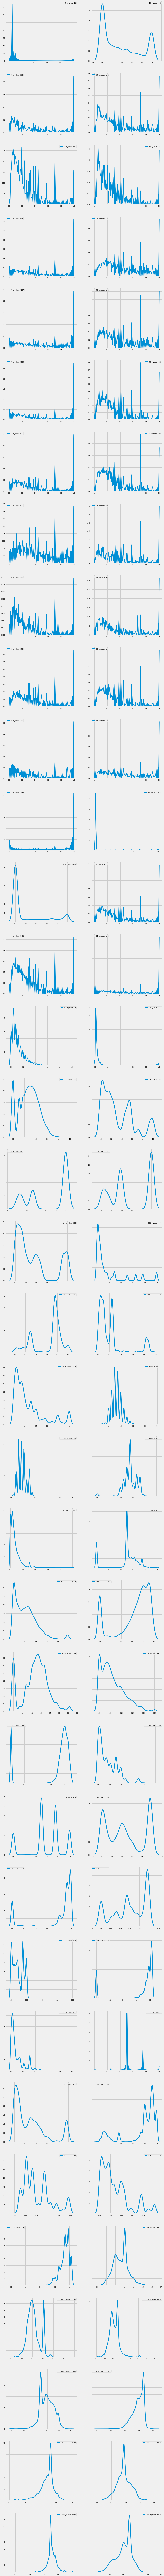

In [726]:
#discovering numerical features
plt.rcParams['figure.figsize'] = 15, 265
fig, ax = plt.subplots(nrows=36, ncols=2)

i = 0
for row in ax:
    for col in row:
        n_values = xtrain[num_cols[i]].nunique()
        sns.kdeplot(xtrain[num_cols[i]],ax=col, label=num_cols[i]+"  n_values:  " + str(n_values) )
        i += 1


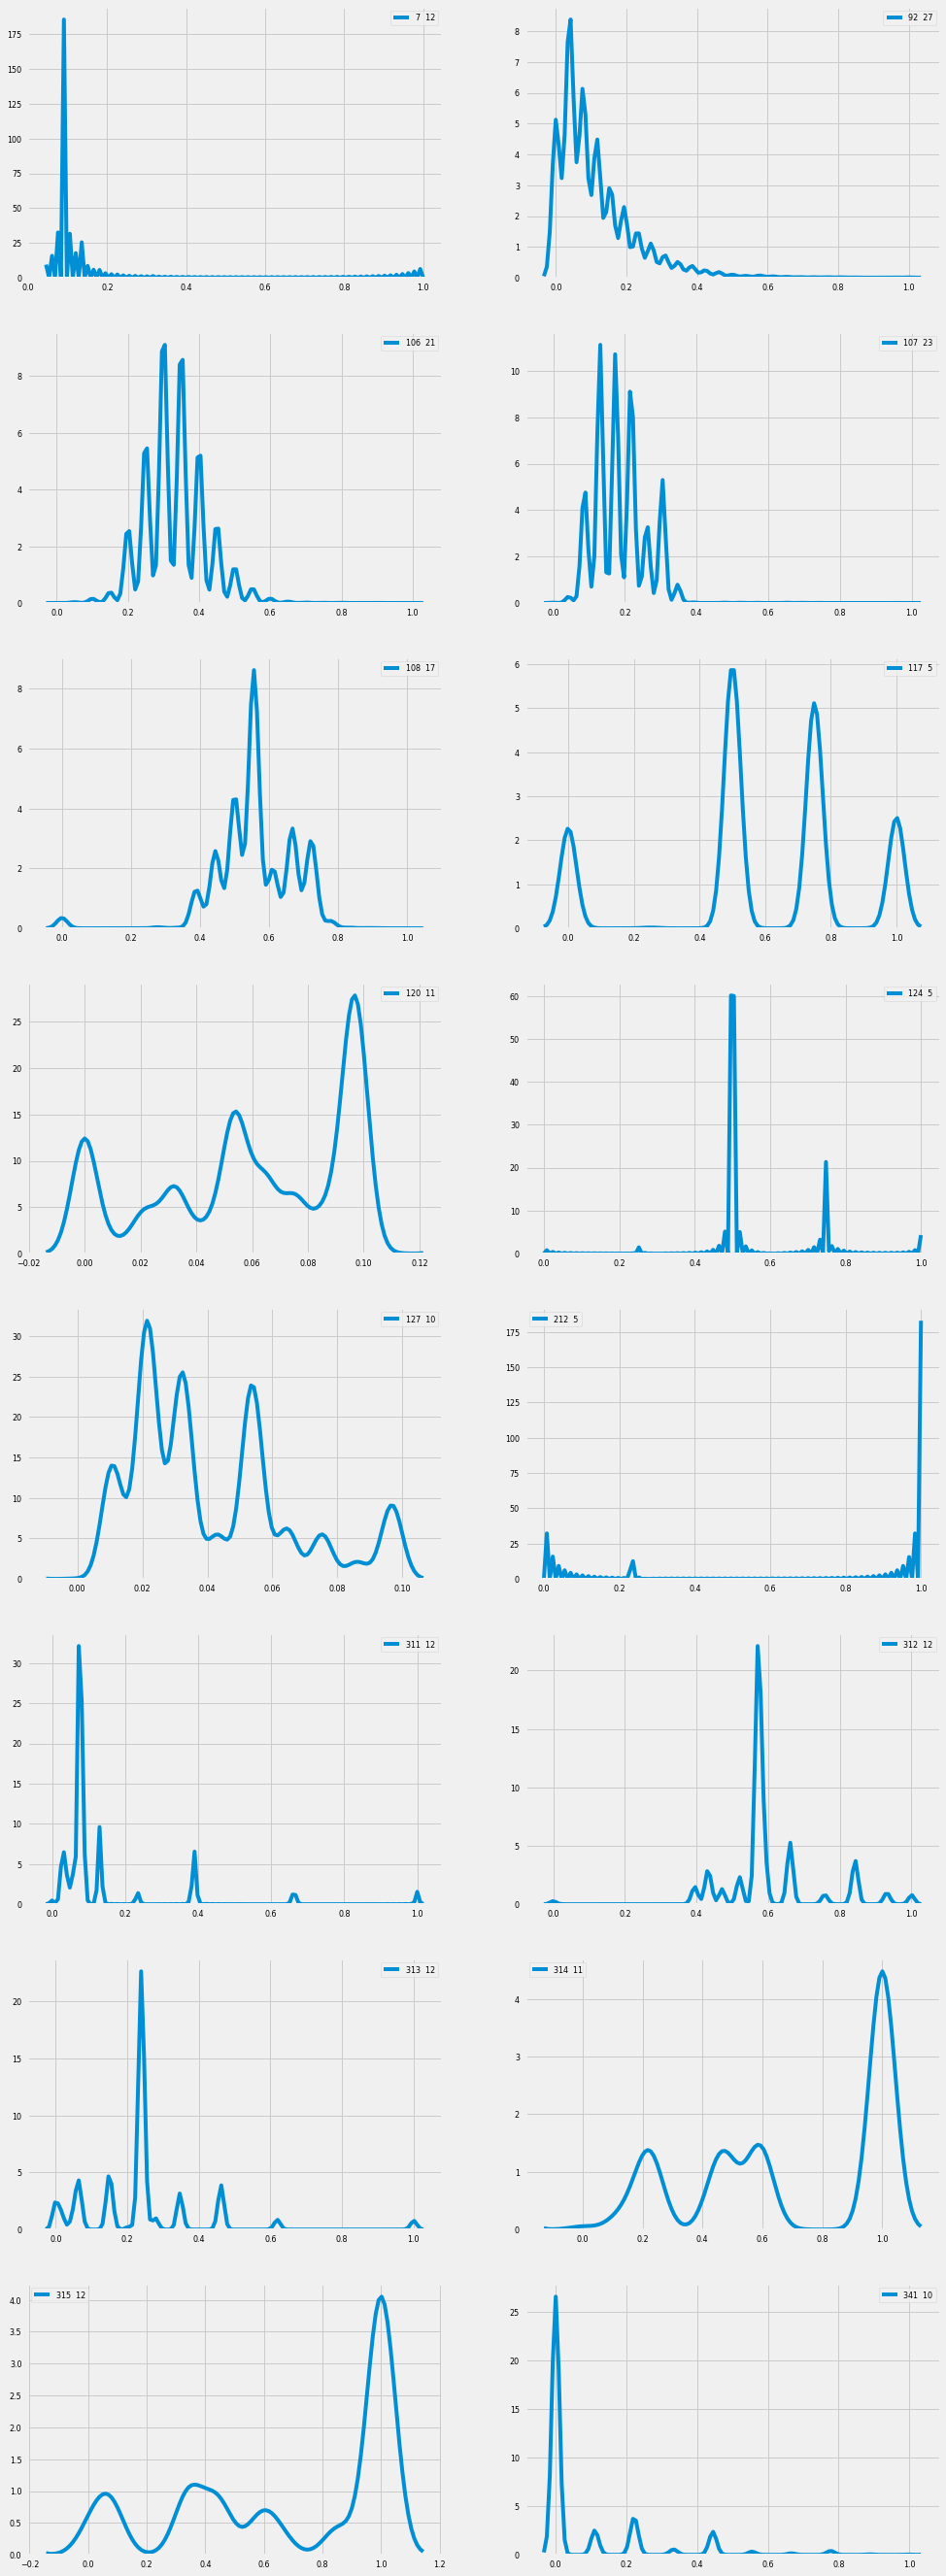

In [727]:
# mb they are categorical hmm
num_cols = [col for col in xtrain if xtrain[col].nunique() > 2 and xtrain[col].nunique() < 32 ]
plt.rcParams['figure.figsize'] = 15, 45

fig, ax = plt.subplots(nrows=8, ncols=2)

i = 0
for row in ax:
    for col in row:
        n_values = xtrain[num_cols[i]].nunique()
        sns.kdeplot(xtrain[num_cols[i]],ax=col, label=num_cols[i]+"  " + str(n_values) )
        i += 1


In [728]:
# mb they are categorical hmm (a little bit deapper)
for col in num_cols :
    print(col,f"\nNumber of values in train  {xtrain[col].nunique()}\nNumber of values in test  {xtest[col].nunique()}")
    print(xtrain[col].value_counts())
    print(xtest[col].value_counts())

7 
Number of values in train  12
Number of values in test  10
0.090909    26997
0.136364     2580
0.045455      332
0.181818      273
0.318182       83
0.227273       59
0.272727       21
0.363636       20
0.409091        8
0.454545        2
0.545455        1
1.000000        1
Name: 7, dtype: int64
0.090909    3724
0.136364     340
0.045455      39
0.181818      37
0.318182      12
0.272727       5
0.227273       4
0.363636       3
0.409091       1
0.454545       1
Name: 7, dtype: int64
92 
Number of values in train  27
Number of values in test  22
0.038462    7627
0.076923    5404
0.000000    4379
0.115385    3922
0.153846    2656
0.192308    1932
0.230769    1365
0.269231     940
0.307692     656
0.346154     447
0.384615     334
0.423077     216
0.461538     154
0.500000      89
0.576923      64
0.538462      51
0.615385      38
0.653846      25
0.692308      17
0.769231      14
0.730769      13
0.807692      10
1.000000       8
0.846154       6
0.961538       5
0.923077       4
0.8

In [745]:
#also lets check whether some features are ohe-ed
pd.options.display.max_columns=350
xtrain.head(10)

,1,2,3,4,6,7,8,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,131,132,133,134,135,136,139,142,143,144,145,146,147,148,151,152,153,154,155,156,157,158,159,160,161,162,163,165,166,167,168,169,170,171,172,173,174,175,176,177,179,180,181,182,183,184,185,187,189,190,191,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,302,304,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,1,0,0,0,0,0.090909,0,1,1,0.461538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,0,0.222222,1,1,1,1
1,1,0,0,1,0,0.090909,0,1,1,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0.0,0.00000,0.00000,0.0,0.00000,0.46291,0.00000,0.15430,0.0,0.0,0.15430,0.00000,0.0,0.0,0.0,0.0,0.46291,0.46291,0.30861,0.00000,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0.111111,1,1,1,0
2,1,0,0,1,0,0.090909,0,1,1,0.200000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.00000,0.00000,0.0,0.00000,

In [746]:
xtrain[['1', '2', '3']].sum(axis=1).value_counts(normalize=True)

1    1.0
dtype: float64

In [747]:
xtrain[['224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', 
       '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', 
       '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263',
       '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '280', '281', '282', '283',
       '284', '285', '286', '287', '288', '289', '290', '292', '293', '294', '295', '296', '297', '298', '299', '300',
       '302', '304', '306', '307', '308', '309', '310']].sum(axis=1).value_counts(normalize=True)

1    0.965566
0    0.034434
dtype: float64

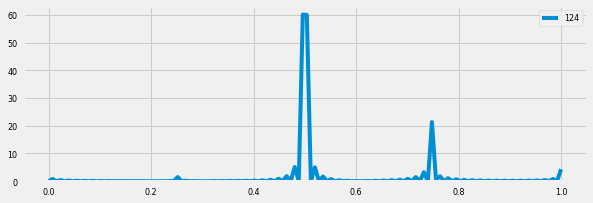

In [732]:
plt.rcParams['figure.figsize'] = 9, 3
sns.kdeplot(xtrain['124'])

In [733]:
# skladni prykoly

In [734]:
# by Stas Semenov

import time


class SemenovEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    normalni_y = []
    se = SemenovEncoding()
    new_skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
        normalni_y.append(new_train_y.iloc[new_val_split])
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val, normalni_y       

In [753]:
%%time

new_train_dfs = []
new_val_dfs = []

new_y_train_dfs = []
new_y_val_dfs = []

main_train_dfs = []

for train_split, val_split in skf.split(xtrain, ytrain): 
    # 5)
    temp_train_dfs, temp_val_df, temp_y_train_dfs = create_new_df_with_categorical_encodings(
        xtrain.iloc[train_split], 
        ytrain.iloc[train_split], 
        xtrain.iloc[val_split], 
        num_cols
    )
    # 6)
    new_y_train_dfs.append(temp_y_train_dfs)
    new_y_val_dfs.append(ytrain.iloc[val_split])
    
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = SemenovEncoding()
    se.fit(xtrain.iloc[train_split], ytrain.iloc[train_split], num_cols)
    main_train_dfs.append(
        se.transform(xtrain.iloc[val_split], inplace=False)
    )
    
se.fit(xtrain, ytrain, features=num_cols)
main_test = se.transform(xtest, inplace=False)

CPU times: user 1min 2s, sys: 20.1 s, total: 1min 22s
Wall time: 1min 34s


In [754]:
new_train_dfs = [pd.concat(i, axis=0, ignore_index=True) for i in new_train_dfs]
new_y_train_dfs = [pd.concat(i, axis=0, ignore_index=True) for i in new_y_train_dfs]

In [742]:
# не ухудшило 
k= 0
scores = []
for tr, y_tr, val, y_val in zip(new_train_dfs, new_y_train_dfs, new_val_dfs, new_y_val_dfs):
    
    k+=1
    lr = LogisticRegression(random_state=42)
    lr.fit(tr, y_tr)
    
    xgb_predictions = lr.predict_proba(val)[:, 1]
    score = roc_auc_score(  y_val, xgb_predictions )
    scores.append(score)
    print(f"On {k} Fold : {score}")
print(f"CV {np.mean(scores)}")

On 1 Fold : 0.7246492727693142
On 2 Fold : 0.7204061461132865
On 3 Fold : 0.7240697815464977
On 4 Fold : 0.7551968111609368
On 5 Fold : 0.7157686193560633
On 6 Fold : 0.726065912164567
On 7 Fold : 0.7253363712959997
On 8 Fold : 0.7277316149857003
CV 0.7274030661740456


In [ ]:
CV 0.7260947833228742
CV 0.7274030661740456

In [743]:
0.7274030661740456 - 0.7260947833228742

0.0013082828511713496

In [749]:
k= 0
scores = []
for tr, y_tr, val, y_val in zip(new_train_dfs, new_y_train_dfs, new_val_dfs, new_y_val_dfs):
    
    k+=1
    xgb_train = xgb.DMatrix(tr, y_tr)
    xgb_test = xgb.DMatrix(val)
    xgb_model = xgb.train(params_xgb, xgb_train, len(results))
    xgb_predictions = xgb_model.predict(xgb_test)
    score = roc_auc_score( y_val , xgb_predictions)
    scores.append(score)
    print(f"On {k} Fold : {score}")
print(f"CV {np.mean(scores)}")

On 1 Fold : 0.7415819778703532
On 2 Fold : 0.7374620464047853
On 3 Fold : 0.7475100356697459
On 4 Fold : 0.7676529764870572
On 5 Fold : 0.7373582935914774
On 6 Fold : 0.7405001542221273
On 7 Fold : 0.7502305766195544
On 8 Fold : 0.7515615840127216
CV 0.7467322056097278


In [755]:
params_lgb = {
    #default
    'objective': 'binary',
    'learning_rate': 0.01,
    'num_threads': 4,
    "metric": 'auc',
    "seed": 42,
    
    #regularization
    'colsample_bytree': 0.66,
    'subsample': 0.8,
    'subsample_freq': 1,
    
    'max_depth': 8, 
    'num_leaves': 128, 
    'min_data_in_leaf' : 17
    
    }

n_rounds = 10000
lgb_train = lgb.Dataset(xtrain, label=ytrain,  free_raw_data=False)
result = lgb.cv(params_lgb, lgb_train, n_rounds, folds=skf.split(xtrain, ytrain), 
                early_stopping_rounds=50, verbose_eval=1, )
result['auc-mean'][-1]

[1]	cv_agg's auc: 0.676039 + 0.0104639
[2]	cv_agg's auc: 0.694946 + 0.00773686
[3]	cv_agg's auc: 0.705338 + 0.00831292
[4]	cv_agg's auc: 0.710346 + 0.00742703
[5]	cv_agg's auc: 0.713366 + 0.00671345
[6]	cv_agg's auc: 0.71552 + 0.00775324
[7]	cv_agg's auc: 0.716476 + 0.00840844
[8]	cv_agg's auc: 0.717386 + 0.00777885
[9]	cv_agg's auc: 0.718749 + 0.00699781
[10]	cv_agg's auc: 0.71961 + 0.00685962
[11]	cv_agg's auc: 0.719811 + 0.00677607
[12]	cv_agg's auc: 0.720337 + 0.00674986
[13]	cv_agg's auc: 0.721143 + 0.00671426
[14]	cv_agg's auc: 0.721573 + 0.0066056
[15]	cv_agg's auc: 0.72175 + 0.00646456
[16]	cv_agg's auc: 0.721847 + 0.00641165
[17]	cv_agg's auc: 0.723002 + 0.00610389
[18]	cv_agg's auc: 0.723383 + 0.0060247
[19]	cv_agg's auc: 0.723318 + 0.00606046
[20]	cv_agg's auc: 0.723313 + 0.00613975
[21]	cv_agg's auc: 0.723707 + 0.00578125
[22]	cv_agg's auc: 0.723695 + 0.00563119
[23]	cv_agg's auc: 0.724146 + 0.00549531
[24]	cv_agg's auc: 0.724572 + 0.00497012
[25]	cv_agg's auc: 0.724937 + 0

[200]	cv_agg's auc: 0.738876 + 0.00595498
[201]	cv_agg's auc: 0.738921 + 0.00601916
[202]	cv_agg's auc: 0.738966 + 0.00603214
[203]	cv_agg's auc: 0.739016 + 0.0060466
[204]	cv_agg's auc: 0.739014 + 0.00603429
[205]	cv_agg's auc: 0.738998 + 0.00606744
[206]	cv_agg's auc: 0.739071 + 0.0061177
[207]	cv_agg's auc: 0.739138 + 0.00608234
[208]	cv_agg's auc: 0.739158 + 0.00607288
[209]	cv_agg's auc: 0.739182 + 0.00607109
[210]	cv_agg's auc: 0.739295 + 0.00612821
[211]	cv_agg's auc: 0.739359 + 0.00612265
[212]	cv_agg's auc: 0.739409 + 0.00611685
[213]	cv_agg's auc: 0.739429 + 0.00617582
[214]	cv_agg's auc: 0.739417 + 0.00614863
[215]	cv_agg's auc: 0.739464 + 0.00619034
[216]	cv_agg's auc: 0.739498 + 0.00624661
[217]	cv_agg's auc: 0.739543 + 0.00626355
[218]	cv_agg's auc: 0.739508 + 0.00627431
[219]	cv_agg's auc: 0.73955 + 0.00626743
[220]	cv_agg's auc: 0.739612 + 0.00634098
[221]	cv_agg's auc: 0.739673 + 0.0063826
[222]	cv_agg's auc: 0.739729 + 0.00641141
[223]	cv_agg's auc: 0.739789 + 0.00642

[397]	cv_agg's auc: 0.745328 + 0.0075149
[398]	cv_agg's auc: 0.74533 + 0.00750897
[399]	cv_agg's auc: 0.745314 + 0.00752287
[400]	cv_agg's auc: 0.74533 + 0.00752864
[401]	cv_agg's auc: 0.74538 + 0.00754144
[402]	cv_agg's auc: 0.745378 + 0.00753749
[403]	cv_agg's auc: 0.745389 + 0.00754878
[404]	cv_agg's auc: 0.745449 + 0.00757599
[405]	cv_agg's auc: 0.74543 + 0.00758765
[406]	cv_agg's auc: 0.745475 + 0.00755889
[407]	cv_agg's auc: 0.745498 + 0.00756263
[408]	cv_agg's auc: 0.745537 + 0.00755457
[409]	cv_agg's auc: 0.745573 + 0.00758733
[410]	cv_agg's auc: 0.745572 + 0.00761961
[411]	cv_agg's auc: 0.745606 + 0.00761729
[412]	cv_agg's auc: 0.745639 + 0.00760605
[413]	cv_agg's auc: 0.745686 + 0.00760418
[414]	cv_agg's auc: 0.745652 + 0.00761846
[415]	cv_agg's auc: 0.745676 + 0.0076219
[416]	cv_agg's auc: 0.745685 + 0.00763912
[417]	cv_agg's auc: 0.745711 + 0.00763961
[418]	cv_agg's auc: 0.745694 + 0.007633
[419]	cv_agg's auc: 0.745685 + 0.00765118
[420]	cv_agg's auc: 0.74571 + 0.00765074
[

[595]	cv_agg's auc: 0.7473 + 0.00829992
[596]	cv_agg's auc: 0.747293 + 0.00833306
[597]	cv_agg's auc: 0.7473 + 0.00832399
[598]	cv_agg's auc: 0.747315 + 0.00831059
[599]	cv_agg's auc: 0.74732 + 0.00830203
[600]	cv_agg's auc: 0.747334 + 0.00831756
[601]	cv_agg's auc: 0.747322 + 0.00833457
[602]	cv_agg's auc: 0.747364 + 0.00831519
[603]	cv_agg's auc: 0.747376 + 0.00834227
[604]	cv_agg's auc: 0.747411 + 0.00835644
[605]	cv_agg's auc: 0.747404 + 0.00836722
[606]	cv_agg's auc: 0.747411 + 0.00836327
[607]	cv_agg's auc: 0.747444 + 0.00836831
[608]	cv_agg's auc: 0.747433 + 0.00836381
[609]	cv_agg's auc: 0.74744 + 0.0083978
[610]	cv_agg's auc: 0.747456 + 0.00841458
[611]	cv_agg's auc: 0.747444 + 0.00842551
[612]	cv_agg's auc: 0.747453 + 0.00840631
[613]	cv_agg's auc: 0.747457 + 0.00840171
[614]	cv_agg's auc: 0.747491 + 0.00841623
[615]	cv_agg's auc: 0.747493 + 0.00840128
[616]	cv_agg's auc: 0.747467 + 0.00841059
[617]	cv_agg's auc: 0.747484 + 0.00841133
[618]	cv_agg's auc: 0.747501 + 0.00841117

[792]	cv_agg's auc: 0.747836 + 0.00883572
[793]	cv_agg's auc: 0.747843 + 0.00882523
[794]	cv_agg's auc: 0.747848 + 0.00881167
[795]	cv_agg's auc: 0.747836 + 0.00881616
[796]	cv_agg's auc: 0.747845 + 0.00881933
[797]	cv_agg's auc: 0.747856 + 0.00884622
[798]	cv_agg's auc: 0.747843 + 0.00882519
[799]	cv_agg's auc: 0.747845 + 0.00879919
[800]	cv_agg's auc: 0.747865 + 0.00881475
[801]	cv_agg's auc: 0.747875 + 0.00882126
[802]	cv_agg's auc: 0.747895 + 0.00885277
[803]	cv_agg's auc: 0.747894 + 0.00887849
[804]	cv_agg's auc: 0.747901 + 0.0088754
[805]	cv_agg's auc: 0.747875 + 0.00886223
[806]	cv_agg's auc: 0.74788 + 0.00890531
[807]	cv_agg's auc: 0.747878 + 0.00890443
[808]	cv_agg's auc: 0.747859 + 0.00891378
[809]	cv_agg's auc: 0.747869 + 0.00889347
[810]	cv_agg's auc: 0.747855 + 0.0088992
[811]	cv_agg's auc: 0.747865 + 0.00888271
[812]	cv_agg's auc: 0.747875 + 0.0089186
[813]	cv_agg's auc: 0.74786 + 0.00893413
[814]	cv_agg's auc: 0.747848 + 0.00891968
[815]	cv_agg's auc: 0.747858 + 0.008933

0.7479643146488338

In [759]:
k= 0
scores = []
for tr, y_tr, val, y_val in zip(new_train_dfs, new_y_train_dfs, new_val_dfs, new_y_val_dfs):
    
    k+=1
    lgb_train = lgb.Dataset(tr, y_tr,  free_raw_data=False)
 
    lgb_test = lgb.Dataset(val, free_raw_data=False)
    lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))
    
    xgb_predictions = lgb_model.predict(val)
    score = roc_auc_score( y_val , xgb_predictions)
    scores.append(score)
    print(f"On {k} Fold : {score}")
print(f"CV {np.mean(scores)}")

On 1 Fold : 0.7409077211164137
On 2 Fold : 0.741030442479218
On 3 Fold : 0.7474214298981459
On 4 Fold : 0.7668370228011485
On 5 Fold : 0.7375661375661376
On 6 Fold : 0.7431110162051866
On 7 Fold : 0.7470245766432886
On 8 Fold : 0.7510005102827917
CV 0.7468623571240414


In [ ]:
lgb_model = lgb.train(params_lgb, lgb_train, len(result['auc-mean']))

lgb_predictions = lgb_model.predict(xtest)